# Predicting Disease Activity, Project Group 7
# Predicting COVID-19 Cases Using Time Series Analysis with Neural Networks
---
Taras Holovko, Jason Lee, Seeam Shahid Noor

Our notebook is structured as follows:
1. Problem statement
2. EDA and how it informed our approach
3. Different models we considered (and results for each)
    - Vanilla NN
    - Vanilla LSTM
    - Vanilla GRU
    - Stacked LSTM
    - Stacked GRU
    - Conditional LSTM
4. Comparison of model (based upon RMSE)
5. Discussion (including insights, limitations, and future work)
6. References

# 1. Problem Statement
---
Everyday American life has radically changed in order to mitigate the spread of COVID-19, which has infected more than one million people and claimed over 70,000 lives (Times, 2020). As of the beginning of May 2020, 26 states have instituted stay-at home policies, which have slowed the spread of the virus by decreasing the movement of infected individuals, but also limited daily business interactions (Mervosh et al., 2020). Due to the given circumstances, more than 30 million Americans—approximately 15 percent of the workforce—have filed for unemployment benefits in March and April, and the U.S. gross domestic product fell at a 4.8 percent annual rate in the first quarter of 2020 (Sherman, 2020). This is the first market decline since 2014 and the worst quarterly contraction since the Great Recession in 2008 (Casselman, 2020). In order for the nation to successfully reopen the economy and return to pre-pandemic daily life, public health experts rely upon models to inform their policy decisions. 

For background context, traditional epidemiological modeling relies on statistical models that make assumptions about a number of things---including $R_0$, social distancing adherence, hospital capacity---to arrive at estimates for deaths over an extended period of time. The predictions of such models are based upon underlying principles related to disease spread that have been studied over time. Given that most  epidemiological models are likely based upon differential equations,  for which input variables and assumptions are altered to arrive at estimates, we unfortunately will not be using such models --- given that they do not correspond to our area of interest --- neural networks --- which usually do not take such specific assumptions into account and instead create a blackbox predictor for a target variable.

Recent applications of neural networks in epidemiological studies have helped construct prediction models of several infectious diseases, like predicting the number of confirmed dengue cases (Aburas et al., 2010). Novel models like that of long short term memory (LSTM) recurrent neural networks have been used to forecast influenza trends.  Researchers Liu, Han and Zhou, and Wang used a LSTM model with novel data sources like virologic surveillance, influenza geographic spread, Google trends, and more to predict influenza trends (Liu et al., 2018). Further advancements in the field include the use of Gated Recurrent Unit (GRU) for influenza prediction. Authors Aiken, Nguyen, and Santillana use GRU to predict influenza at the state- and city-level in the US with the use of Internet search data (Emily Aiken et al., 2019). In our analysis, we will implement these model approaches and adaptations thereof in our attempt to accurately model and predict confirmed COVID-19 cases. We will discuss this in further depth in part (3), models.

In our exploratory analysis of the COVID-19 dataset compiled from the John Hopkins University Center for Systems Science and Engineering (CSSE) and World Health Organization, we observed that while the number of confirmed cases has steadily increased in nearly all of the states in the US, the mortality and hospitalization rate exhibit distinct spatial trends: select states in the Midwest and South are demonstrate larger mortality rates than other states. As reported by the Center for Disease Control and Prevention (CDC), a greater proportion of minority groups are 1) susceptible to being infected and 2) have died from COVID-19 than white Americans (CDC, 2020). As such, in later analysis, we will consider socioeconomic factors at the state-level in our model to account for this troubling trend.

# 2. EDA of COVID-19 Data

### Map Visualizations
#### Mean Number of Confirmed Cases
We observe that the greatest number of confirmed cases can be found in New York, New Jersey, and beyond. As shown in the density plot of confirmed cases, the number is overwhelming under 50,000. Therefore, it is unsurprising the that states with high number of cases skew the color gradient. We observe similar results in plots of mean deaths and recovered cases.
#### Mean Mortality Rate
When plotting the mean Mortality Rate in each state, we observe greater variation. Interestingly, Michigan reports the highest mean mortality rate. According to the plot, we observe that the Midwestern, Northeastern, Pacific Northwestern, and select Southern states report positive, non-zero mortality rates. This begs the question, why are these regions experiencing higher mortality rates? Given that mean mortality rate is exhibiting a different spatial trend than number of deaths and confirmed cases, this seems to suggest that there are underlying state-level characteristics that are contributing to the variance in mortality rate.

As reported in popular media, a greater proportion of minority groups are 1)  susceptible to being infected and 2) have died from COVID-19 than  white Americans (https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/racial-ethnic-minorities.html). As such, in later analysis, we will consider socioeconomic factors at the state-level in our model to account for this troubling trend.
#### Mean Number of People Tested
Unsurprisingly, New York, California, and other densely populated states with significant number of COVID-19 cases are also states with higher number of completed tests. While further analysis on the severity of COVID-19 outbreaks by state would inform policymakers on how to effectively distribute limited testing supplies, this is outside the scope of our analysis.
#### Mean Hospitalization Rate
Similar to our analysis of Mortality Rate, this plot demonstrates that a wide range of states in the Northeastern, Midwestern, Southern, and Western region of the U.S. are experiencing positive, non-zero hospitalization rates. As aforementioned, there are a number of possible contributing factors like socioeconomic composition, hospital capacity, and beyond that could explain the variation between states. This will inform our model construction later on.
### Time Series Across 50 States
Unsurprising results. We observe steady increase in the number of confirmed cases, recovered cases, number of people tested, and testing rate. Unfortuantely, the number of deaths of deaths have remained relatively constant since late April. We a recent decreasing trend in the mortality rate and hospitalization rate.

We see that nearly all states are still experiencing steep increases in the number of confirmed cases and deaths. Nearly all of the states exhibit linear or concave up increases in confirmed cases and deaths. It appears that Alaska, Hawaii, and Montana are approaching the top of their confirmed cases peak; however, it is too soon to tell if the number of confirmed cases is plateauing or decreasing. We observe that the number of recovered cases is missing some data.

### Takeaways
Some state-level charateristics include the percent of males, median household income, percent of adults uninsured, percent of adults over the age of 65, state gross domestic product, and many other factors. We hypothesize that some of these factors play a role in the variation of confirmed cases across states. We then create a matrix of these auxillary factors to later incoporate into a conditional LSTM. This allows us to capture a more granular picture of key features that may influence our predictions.

In [92]:
# dependencies
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import glob
import string

import tensorflow as tf
from tensorflow.keras import layers, models

import geopandas as gpd # may require install of geopandas, descartes
from shapely.geometry import Point, Polygon
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime
from datetime import timedelta, date

In [109]:
# Define Path
all_dates = sorted(glob.glob("COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports_us/*.csv")) #sorted by date
data_full = []

# initialize date
start_date = date(2020, 4, 12)

# Iteratre through all dates
for i, filename in enumerate(all_dates):
    df = pd.read_csv(filename, index_col=None, header=0)
    df['date'] = start_date + datetime.timedelta(days=i)#filename.split("/",1)[0][:-4]
    df['dataidx'] = i
    data_full.append(df)

# Compile into one df
data_full = pd.concat(data_full)
data_full.head(10)

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,date,dataidx
0,Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,NaN,3470.0,1.0,75.988020,21583.0,437.0,2.610160,84000001,USA,460.300152,12.264945,2020-04-12,0
1,Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,2.0,45.504049,8038.0,31.0,2.941176,84000002,USA,1344.711576,11.397059,2020-04-12,0
2,Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427.0,4.0,48.662422,42109.0,NaN,3.246753,84000004,USA,578.522286,NaN,2020-04-12,0
3,Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,5.0,49.439423,19722.0,130.0,2.109375,84000005,USA,761.753354,10.156250,2020-04-12,0
4,California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,NaN,22155.0,6.0,58.137726,190328.0,5234.0,2.812020,84000006,USA,485.423868,22.961176,2020-04-12,0
5,Colorado,US,2020-04-12 23:18:15,39.0598,-105.3111,7307,289,NaN,7018.0,8.0,128.943729,34873.0,1376.0,3.955112,84000008,USA,615.389991,18.831258,2020-04-12,0
6,Connecticut,US,2020-04-12 23:18:15,41.5978,-72.7554,12035,554,NaN,11481.0,9.0,337.560483,41220.0,1654.0,4.603241,84000009,USA,1156.148159,13.743249,2020-04-12,0
7,Delaware,US,2020-04-12 23:18:15,39.3185,-75.5071,1625,35,191.0,1590.0,10.0,166.878217,11103.0,190.0,2.153846,84000010,USA,1140.214672,11.692308,2020-04-12,0
8,Diamond Princess,US,2020-04-12 23:18:15,NaN,NaN,49,0,0.0,49.0,888.0,NaN,NaN,NaN,0.000000,84088888,USA,NaN,NaN,2020-04-12,0
9,District of Columbia,US,2020-04-12 23:18:15,38.8974,-77.0268,1875,50,493.0,1825.0,11.0,265.675190,10640.0,NaN,2.666667,84000011,USA,1507.618148,NaN,2020-04-12,0


In [110]:
# load data necesssary for viualization of US
usa_viz = gpd.read_file('usa_map/cb_2018_us_state_20m.shp')

# merge viz data with disease data and remove non-contiguous states
usa_viz = usa_viz.merge(data_full.groupby('Province_State').mean(), 
                        left_on='NAME', 
                        right_on='Province_State')
usa_viz = usa_viz.loc[~usa_viz['NAME'].isin(['Alaska', 'Hawaii', 'District of Columbia'])]

In [111]:
# load data necesssary for viualization of US
usa_viz = gpd.read_file('usa_map/cb_2018_us_state_20m.shp')

# merge viz data with disease data and remove non-contiguous states
usa_viz = usa_viz.merge(data_full.groupby('Province_State').mean(), 
                        left_on='NAME', 
                        right_on='Province_State')
usa_viz = usa_viz.loc[~usa_viz['NAME'].isin(['Alaska', 'Hawaii', 'District of Columbia'])]

In [112]:
# adjust df
usa_viz_norm = usa_viz.copy()
usa_viz_norm['Confirmed'] = (usa_viz_norm['Confirmed'] - usa_viz_norm['Confirmed'].mean())/usa_viz_norm['Confirmed'].std()
usa_viz_norm['Deaths'] = (usa_viz_norm['Deaths'] - usa_viz_norm['Deaths'].mean())/usa_viz_norm['Deaths'].std()
usa_viz_norm['Recovered'] = (usa_viz_norm['Recovered'] - usa_viz_norm['Recovered'].mean())/usa_viz_norm['Recovered'].std()
usa_viz_norm['Mortality_Rate'] = (usa_viz_norm['Mortality_Rate'] - usa_viz_norm['Mortality_Rate'].mean())/usa_viz_norm['Mortality_Rate'].std()
usa_viz_norm['People_Tested'] = (usa_viz_norm['People_Tested'] - usa_viz_norm['People_Tested'].mean())/usa_viz_norm['People_Tested'].std()
usa_viz_norm['Hospitalization_Rate'] = (usa_viz_norm['Hospitalization_Rate'] - usa_viz_norm['Hospitalization_Rate'].mean())/usa_viz_norm['Hospitalization_Rate'].std()
usa_viz_norm['Testing_Rate'] = (usa_viz_norm['Testing_Rate'] - usa_viz_norm['Testing_Rate'].mean())/usa_viz_norm['Testing_Rate'].std()

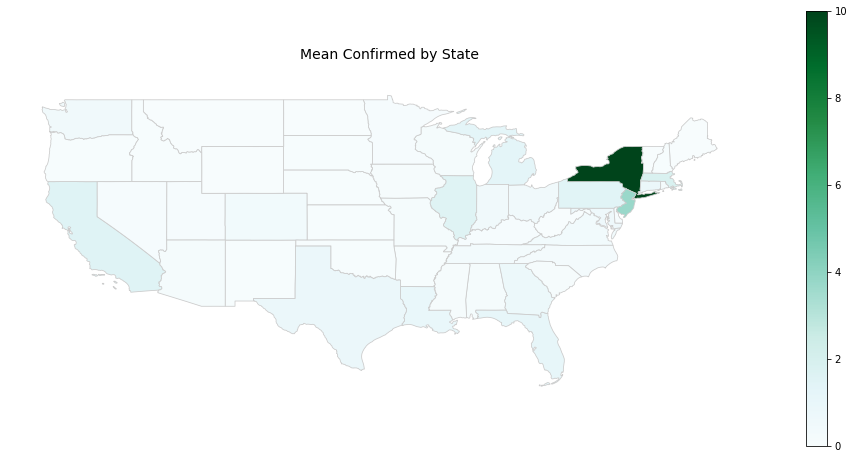

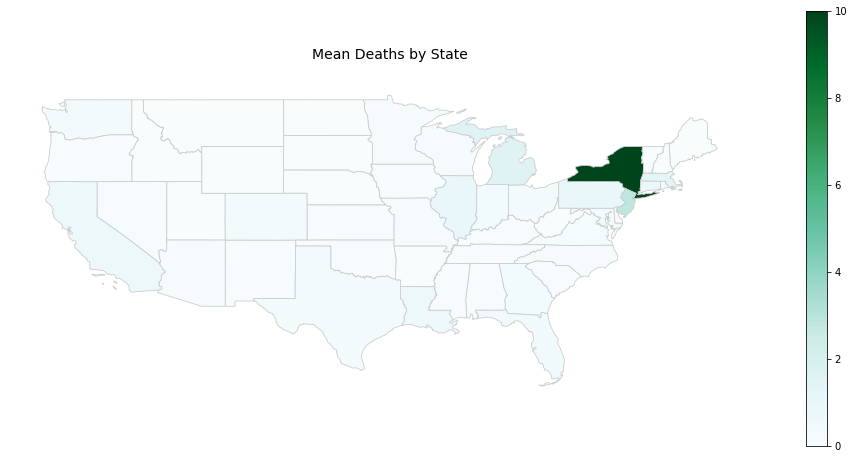

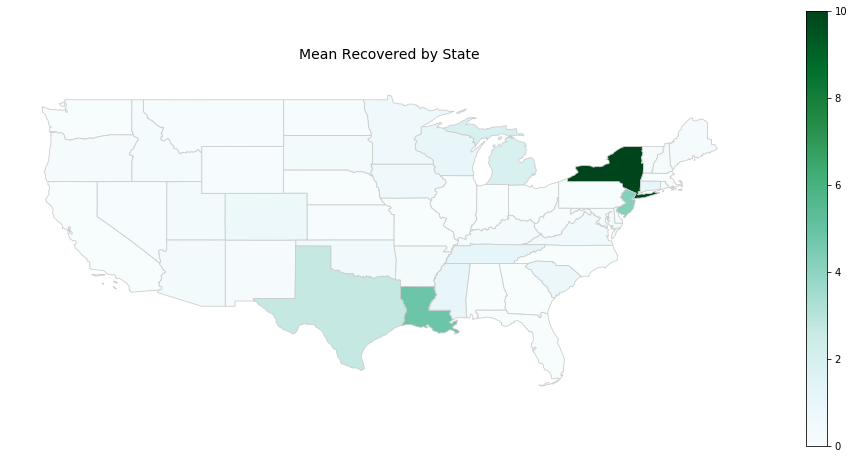

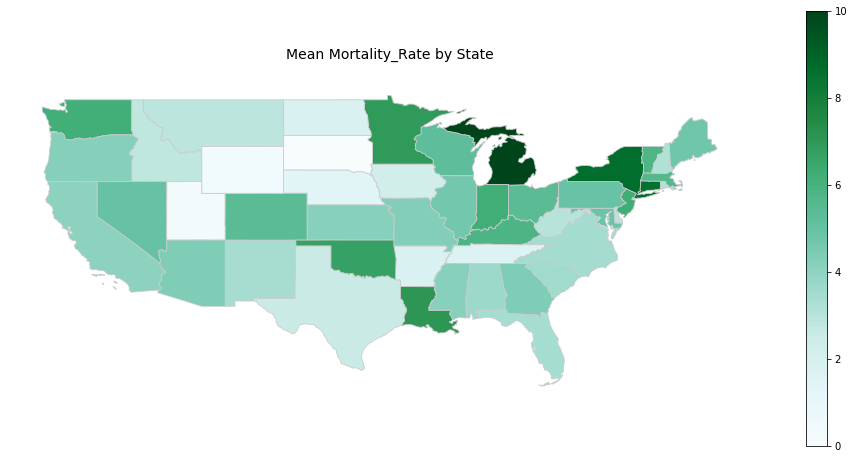

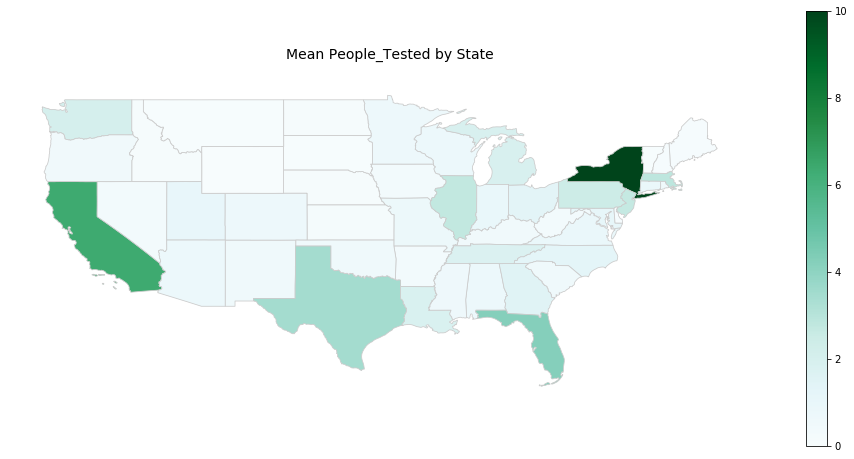

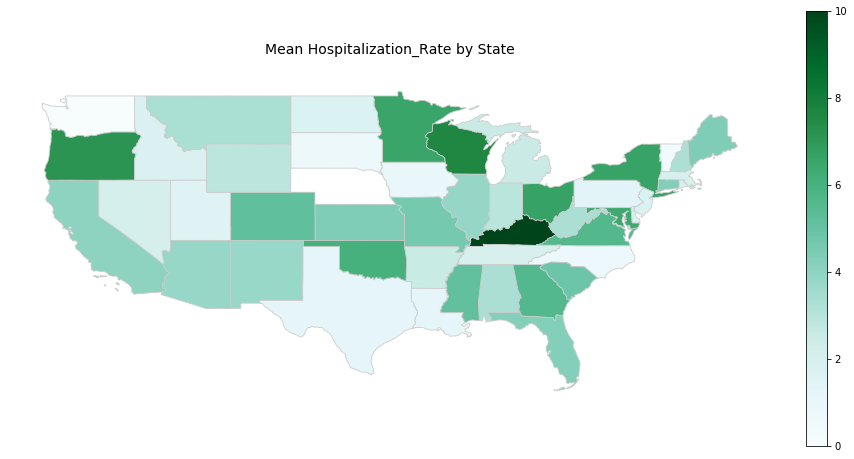

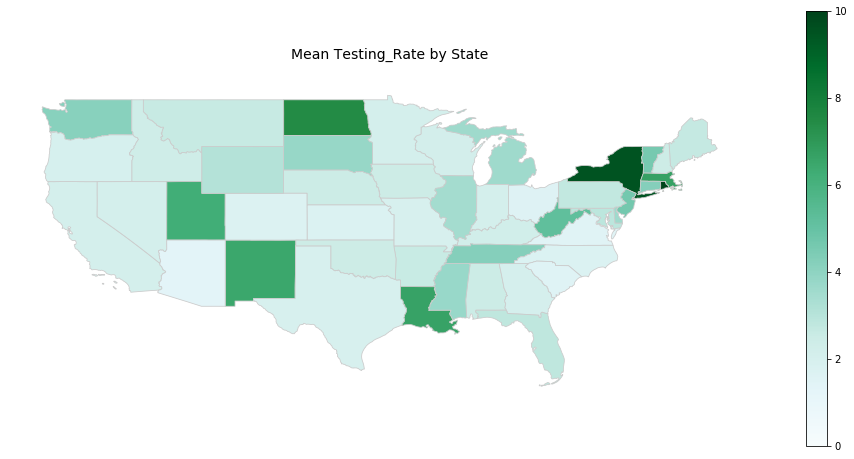

In [113]:
# visualize map of contiguous US with average Confirmed cases, Deaths, and Recovered by state
plotters = ['Confirmed','Deaths', 'Recovered', 'Mortality_Rate', 'People_Tested', 'Hospitalization_Rate', 'Testing_Rate']
for i, column in enumerate(plotters):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    usa_viz_norm.plot(column=column, cmap='BuGn', linewidth=0.8, edgecolor='0.8', ax=ax)
    ax.set_ylim(24, 52)
    ax.set_title('Mean {} by State'.format(column), fontsize=14)
    ax.axis('off');
    sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=10, vmax=0))
    cbar = fig.colorbar(sm, fraction=0.046, pad=0.04)
    plt.show()

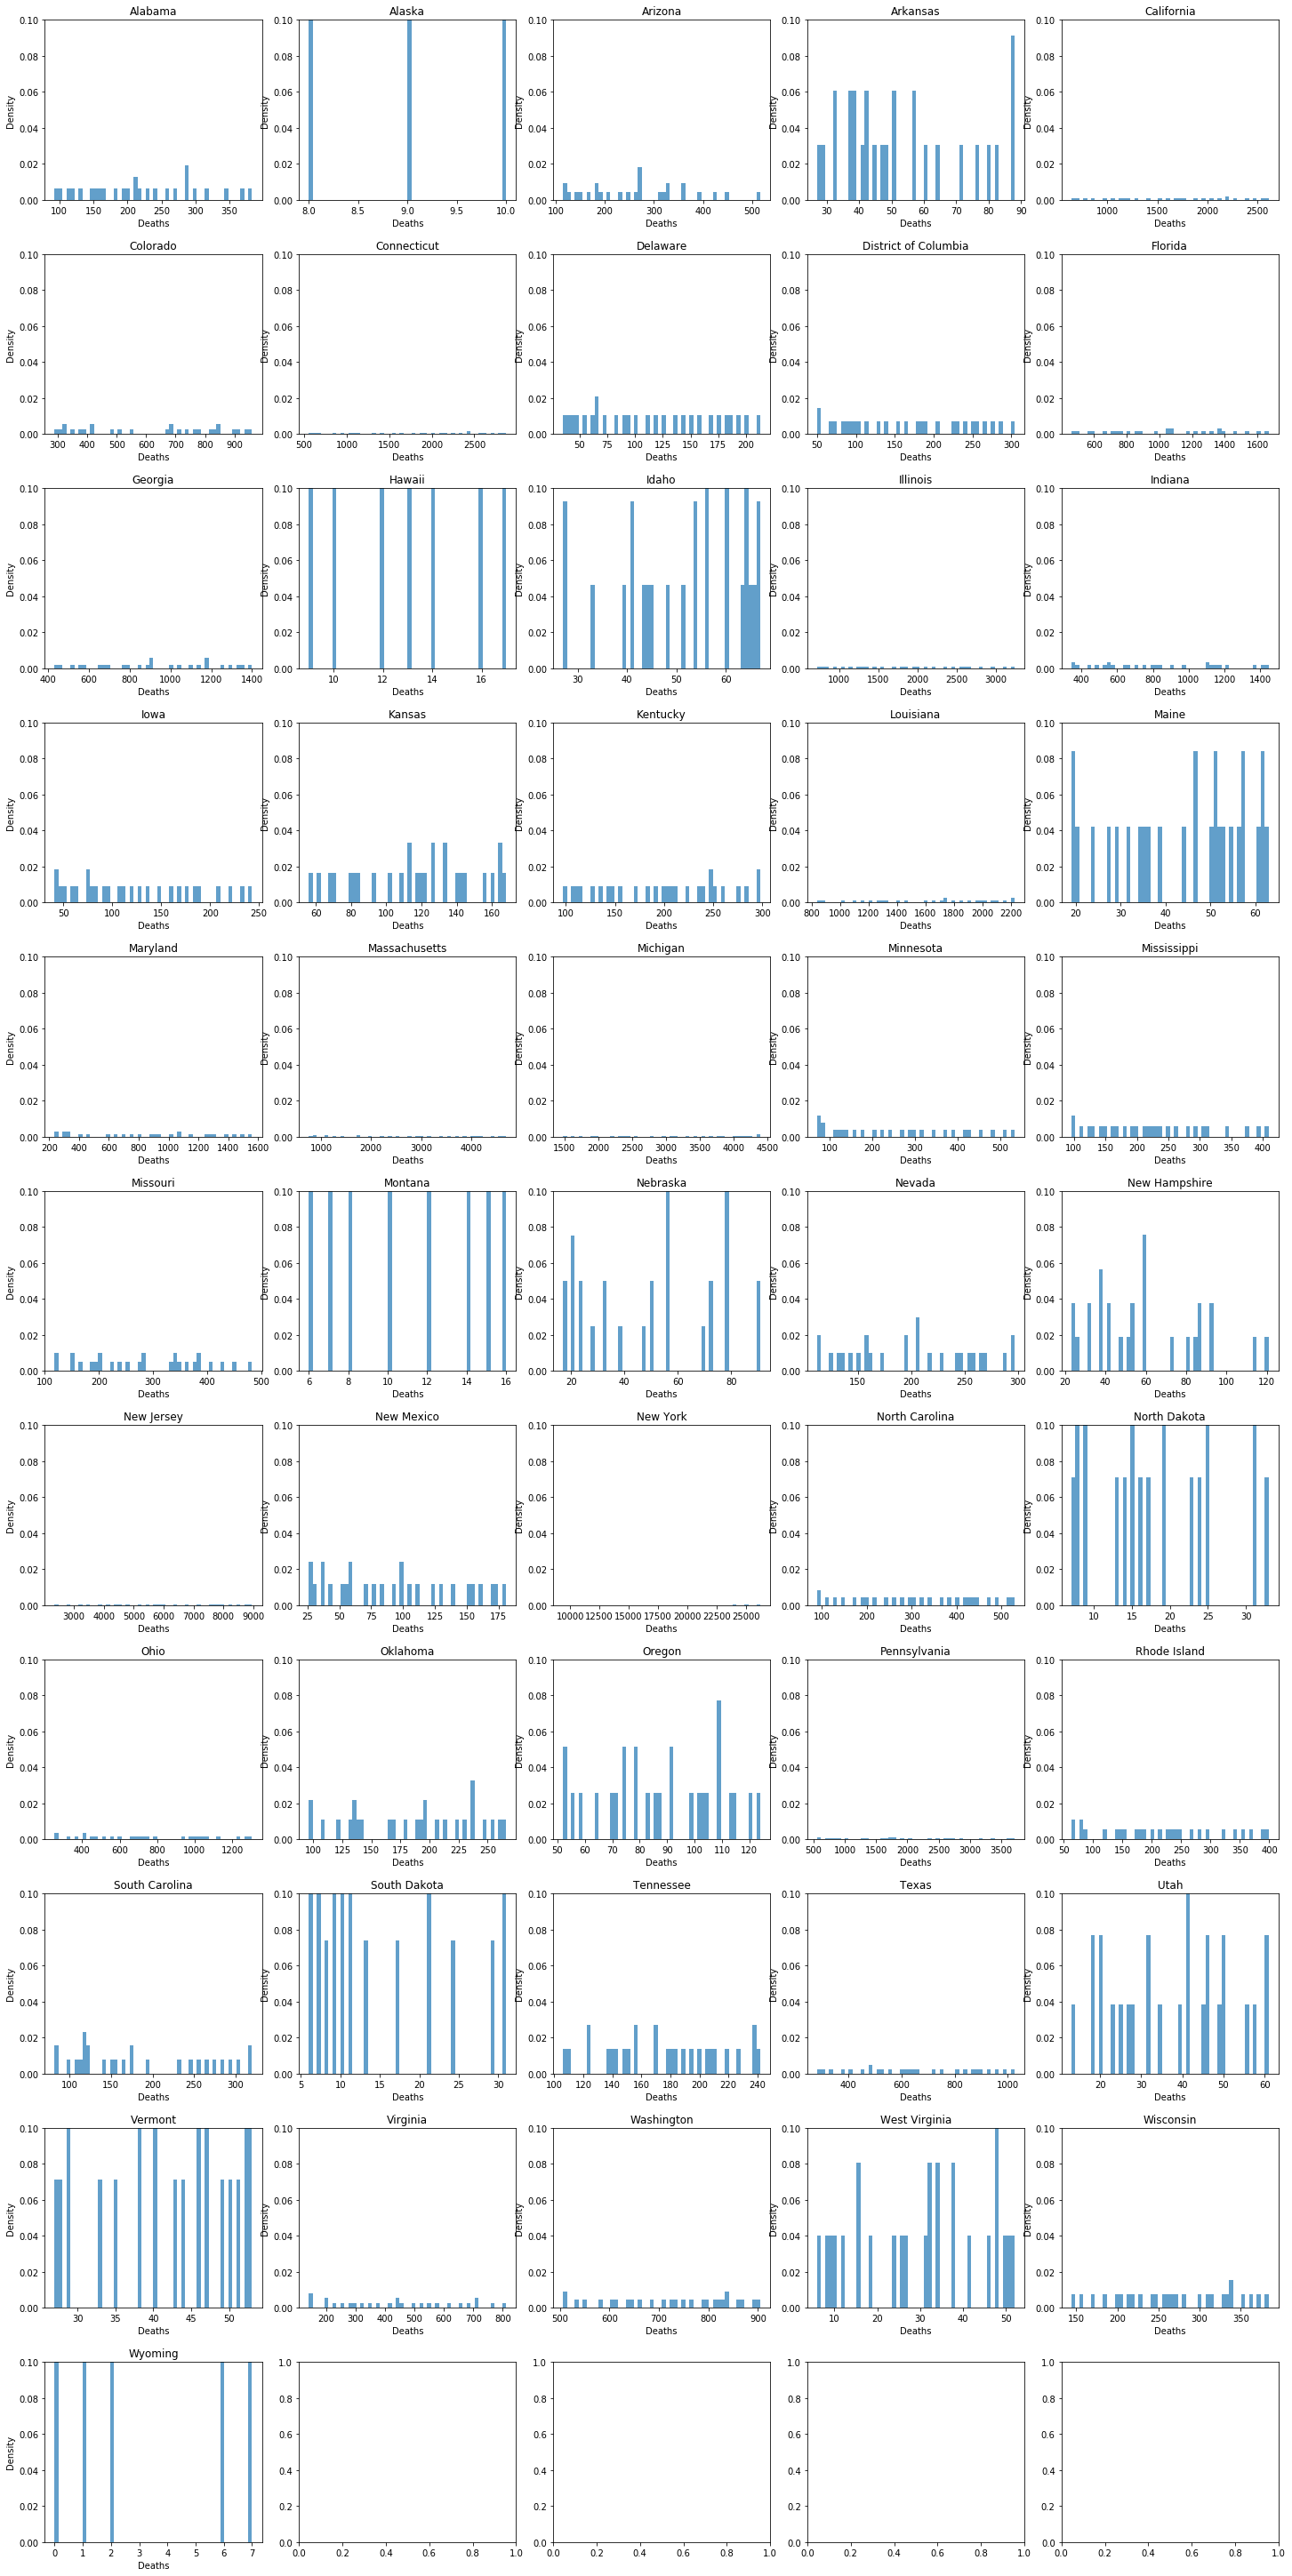

In [114]:
# FIPS encoding
fips_list = [1,2,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,
             35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56]

# plot density of Deaths by each state
fig, ax = plt.subplots(11, 5, figsize=(20, 40))
fig.tight_layout(h_pad=4.0)
for i, ax in zip(fips_list, ax.ravel()):
    state_i = data_full[data_full['FIPS'] == i]
    ax.hist(state_i['Deaths'], bins=50, density=True, alpha=0.7)
    ax.set_title(state_i['Province_State'].iloc[0])
    ax.set_xlabel('Deaths')
    ax.set_ylabel('Density')
    ax.set_ylim(0, 0.1)
plt.show()

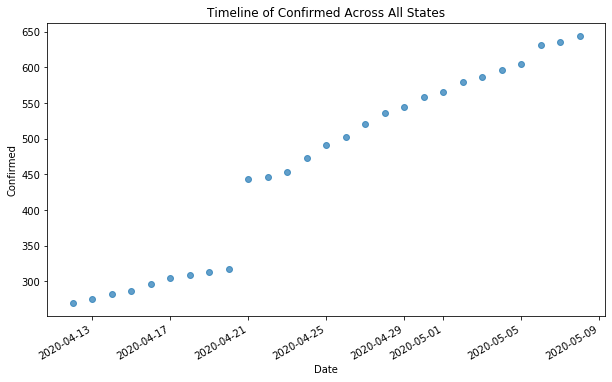

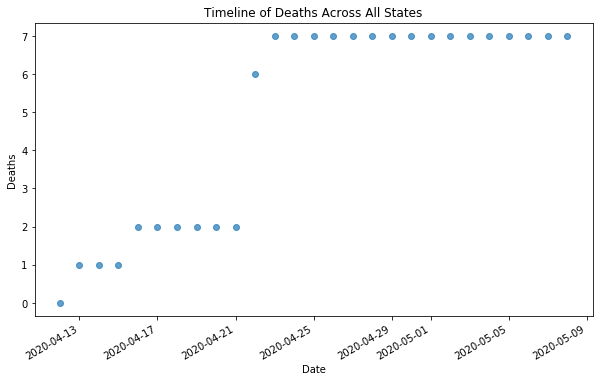

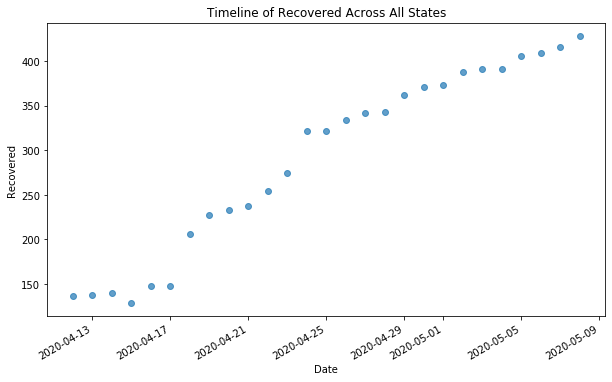

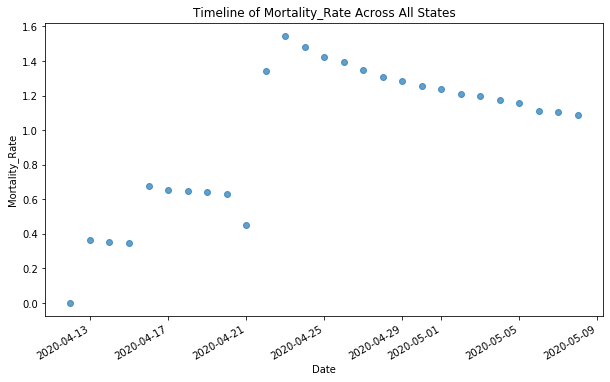

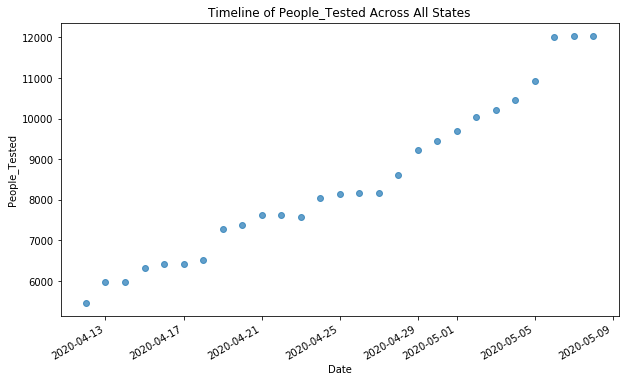

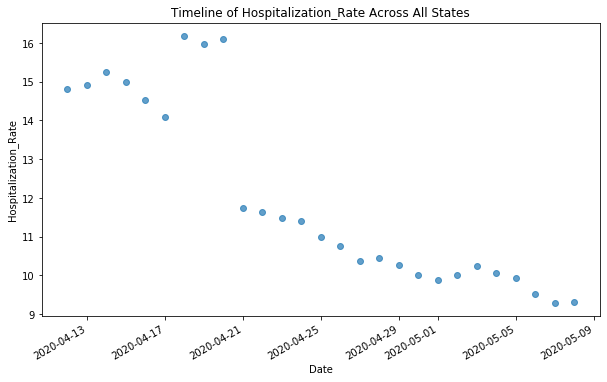

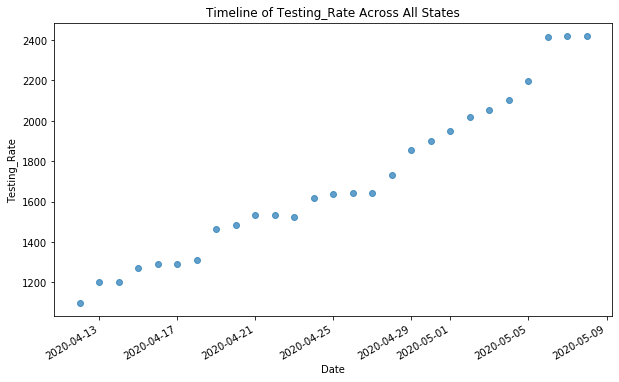

In [115]:
# years class from matplotlib
dates = data_full.date.unique # every year

# plot COVID timeline across all states
for i, column in enumerate(plotters):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot_date(state_i.date, state_i[column], xdate=True, alpha=0.7)
    ax.set_title('Timeline of {} Across All States'.format(column))
    ax.set_xlabel('Date')
    ax.set_ylabel('{}'.format(column))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.format_xdata = mdates.DateFormatter('%m-%d')
    fig.autofmt_xdate()
    plt.show()

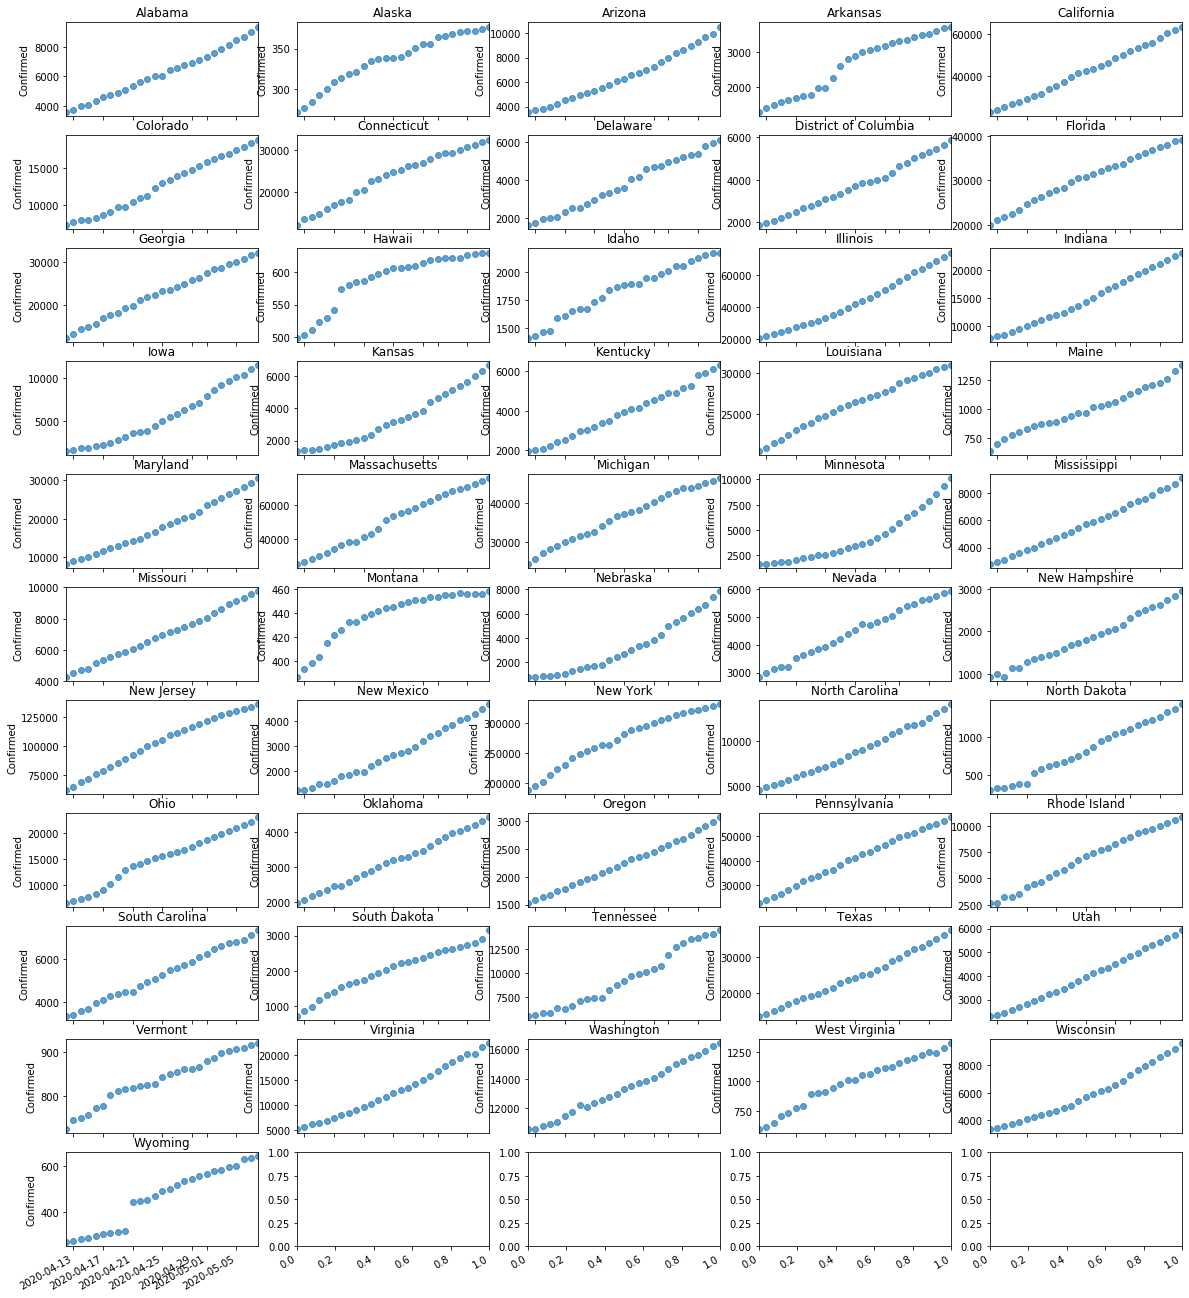

In [118]:
# plot timeline of confirmed over time by each state 
fig, ax = plt.subplots(11, 5, figsize=(20, 25))
for i, ax in zip(fips_list, ax.ravel()):
    state_i = data_full[data_full.FIPS == i]
    ax.plot_date(state_i.date, state_i.Confirmed, xdate=True, alpha=0.7)
    ax.set_xlim(min(state_i.date), max(state_i.date))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.format_xdata = mdates.DateFormatter('%m-%d')
    ax.set_title(state_i.Province_State.iloc[0])
    ax.set_ylabel('Confirmed')
fig.autofmt_xdate()
plt.show()

# 3. Models / Methods

We consider two different tasks and two classes of approaches. The first task is prediction of the number of COVID-19 cases on an 11th day after seeing 10 days of data, and the second task is prediction of the number of COVID-19 cases on the 17th day after seeing data for the 1st through 10th days (i.e., prediction for the number of cases in a week).

In the first class of approaches, we only use time series data in our neural networks and use 5 models: a vanilla feedforward NN, a vanilla LSTM, a vanilla GRU, a stacked LSTM, and a stacked GRU. Each takes 10 days of inputs and attempts to predict the corresponding number of cases on the 11th or 17th day (depending on whether we are considering task 1 or 2) for a given region. All 5 models are trained on all the confirmed cases data for the contiguous U.S. on the county and town level. Descriptions are as follows:

- Vanilla FFNN: A simple feed forward neural network with one hidden layer
- Vanilla LSTM: A simple Long Short-Term Memory neural network with one hidden LSTM layer  
- Stacked LSTM: A deeper Long Short-Term Memory neural network with 2 hidden LSTM layers where the 1st LSTM layer provides a sequence output rather than a single value output to the 2nd LSTM layer.
- Vanilla GRU:  A simple Gated Recurrent Units neural network with one hidden GRU layer
- Stacked GRU: A deeper Gated Recurrent Units neural network with 2 hidden GRU layers where the 1st GRU layer provides a sequence output rather than a single value output to the 2nd GRU layer.  


In the second class of approache, we still use the time series approach described above, but additionally incorporate the use of conditional data (or constants) about each state / region to supplement to our time series data and aid in the prediction of the number of cases. This is motivated by our EDA above, which described the importance of many of the factors we are considering. We consider additional predictive factors such as percent with hypertension, number of hospital beds, percent obese, number of deaths from opioid overdoses, number of hospitals, percent of adults with heart disease, percent of adults with inactive lifestyles, percent of population over the age of 65, state GDP, percent of adults employed, percent of population that is male. Having these additional data is naturally more informative than exclusively time series data. The reason this is important is because there may be critical difference acrosses geographies / states that change the nature of disease growth for that given region.

We describe each of our models briefly below and we compare the results for all the models in part (4).

In [3]:
# import data
path = 'COVID-19-master/csse_covid_19_data/csse_covid_19_time_series'
covid_us = pd.read_csv(path + '/time_series_covid19_confirmed_US.csv', sep=',', error_bad_lines=False)

In [4]:
# remove unnecessary columns and dates preceding March 8 so that dataset is not imbalanced with excess zeros
undesired_cols = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key']
undesired_dates = ['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
                   '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
                   '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', 
                   '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', 
                   '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', 
                   '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', 
                   '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', 
                   '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20']
covid_us = covid_us.drop(columns=undesired_cols)
covid_us = covid_us.drop(columns=undesired_dates)

# remove all entries that are not states
undesired_territories = ['American Samoa', 'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands',
                         'District of Columbia', 'Diamond Princess', 'Grand Princess']

for territory in undesired_territories:
    covid_us = covid_us[covid_us.Province_State != territory]

# print dataframe size
print("Dataframe size:", covid_us.shape)
covid_us

Dataframe size: (3251, 62)


,Province_State,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,...,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20
5,Alabama,0,0,0,0,0,0,0,0,0,...,43,44,42,45,48,53,53,58,61,67
6,Alabama,0,0,0,0,0,0,1,1,1,...,174,174,175,181,187,188,189,196,205,208
7,Alabama,0,0,0,0,0,0,0,0,0,...,37,39,42,43,45,45,47,47,51,53
8,Alabama,0,0,0,0,0,0,0,0,0,...,42,42,42,42,43,42,43,43,44,44
9,Alabama,0,0,0,0,0,0,0,0,0,...,36,37,39,40,40,40,40,42,44,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3256,Utah,0,0,0,0,0,0,0,0,0,...,22,23,23,23,24,25,25,26,27,27
3257,Utah,0,0,0,0,0,0,0,0,0,...,14,12,13,15,11,11,12,12,12,13
3258,Utah,0,0,0,0,0,0,0,0,0,...,93,98,101,103,111,119,121,128,132,138
3259,Utah,0,0,0,0,0,0,0,0,0,...,11,13,13,13,14,14,14,14,14,14


In [5]:
# master constant dataset, to be used later
states_cond = pd.read_csv("conditional_data/state_predictors.csv")

# load up FIPS converter
fips_df = pd.read_csv("conditional_data/fips.csv")

# sort through conditional files
all_cond_files = sorted(glob.glob("conditional_data/constants/*.csv"))

# iter through
for i, filename in enumerate(all_cond_files):
    df_other = pd.read_csv(filename, index_col=None, header=0)
    df_other['State'] = df_other['State'].str.upper()
    merge_step = pd.merge(df_other, fips_df, on='State')
    states_cond = pd.merge(states_cond, merge_step[[merge_step.columns[1],'FIPS']], on='FIPS')

# normalize relevant columns
states_cond['num_staffed_beds_2019'] = (states_cond['num_staffed_beds_2019'] - states_cond['num_staffed_beds_2019'].mean()) / states_cond['num_staffed_beds_2019'].std()
states_cond['income'] = (states_cond['income'] - states_cond['income'].mean()) / states_cond['income'].std()
states_cond['per_heart_dis_2015'] = (states_cond['per_heart_dis_2015'] - states_cond['per_heart_dis_2015'].mean()) / states_cond['per_heart_dis_2015'].std()
states_cond['state_gdp'] = (states_cond['state_gdp'] - states_cond['state_gdp'].mean()) / states_cond['state_gdp'].std()
states_cond = states_cond.drop(columns='State')

# function to change state titling to be capitalized but not uppercase
def change_state_name(row):
    return row['State'].lower().title()

fips_df = fips_df[fips_df.State != 'DISTRICT OF COLUMBIA'] # remove DC
fips_num = fips_df['FIPS'] # get FIPS numbers
fips_states = fips_df.apply(change_state_name, axis=1) # change names
fips_dict = dict(zip(fips_states, fips_num)) # create dictionary with state names and corresponding FIPS
fips_num_dict = dict(zip(fips_num, range(49)))

In [120]:
states_cond[0:10]

,FIPS,income,pov_per,uninsured_per,internet_per,obesity_death_rate_2018,num_hospitals_2019,per_hypertension_2018,per_inactive_2018,per_male,per_obese_2018,per_employed,per_senior,per_heart_dis_2015,num_staffed_beds_2019,state_gdp
0,1,-1.239146,0.168,0.100,0.733,8.3,90,0.419,0.320,0.484802,0.363,0.563,0.169,1.021116,0.050703,-1.329300
1,2,1.667590,0.109,0.144,0.843,8.8,10,0.318,0.206,0.519231,0.342,0.599,0.118,-1.010750,-0.831133,1.956802
2,4,-0.443497,0.140,0.109,0.818,15.9,72,0.307,0.251,0.497235,0.295,0.592,0.175,-0.299597,-0.084291,-1.053543
3,5,-1.523342,0.172,0.090,0.698,7.4,52,0.413,0.325,0.490056,0.350,0.561,0.170,1.783066,-0.428111,-1.509258
4,6,1.102595,0.128,0.085,0.847,5.8,342,0.284,0.200,0.497235,0.251,0.599,0.143,-1.061546,3.612086,1.582759
5,8,0.853717,0.096,0.081,0.857,9.5,55,0.259,0.195,0.502982,0.226,0.674,0.142,-1.315530,-0.401909,0.652528
6,9,1.604882,0.104,0.056,0.838,27.5,34,0.305,0.240,0.487179,0.269,0.639,0.172,-0.909156,-0.364870,1.495914
7,10,0.525861,0.125,0.060,0.824,39.3,8,0.349,0.310,0.483738,0.318,0.602,0.187,0.106777,-0.781727,1.018015
8,12,-0.746847,0.136,0.135,0.808,15.8,214,0.346,0.292,0.488491,0.284,0.575,0.205,0.208370,2.536790,-1.042998
9,13,-0.498483,0.143,0.137,0.790,8.3,111,0.331,0.310,0.486653,0.316,0.602,0.139,0.665540,0.449745,-0.391508


In [6]:
# replace state name with FIPS
for key in fips_dict.keys():
    covid_us = covid_us.replace(key, fips_dict[key])
    
# change training data to numpy array and remove FIPS column for training
covid_us = np.array(covid_us, dtype=float)
covid_train = covid_us[:, 1:]  

In [8]:
# create functions to normalize data using min-max scaling as per 
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3131-8
dataset_max = np.max(covid_train)
dataset_min = np.min(covid_train)
dataset_mean = np.mean(covid_train)
dataset_std = np.std(covid_train)

def normalize_data(data):
    return (data - dataset_mean) / dataset_std

def inv_normalize(data):
    return data * dataset_std + dataset_mean

# normalize COVID training set
covid_norm = normalize_data(covid_train)

In [9]:
# set params
n_states = 50
n_timesteps = 10

# function to create batches of training data
def create_training_batch(training_data, cond_data, lag=5, batch_size=100, lstm=False, conditional=False):
    
    # get minimum value (effectively equivalent to 0)
    min_value = np.min(training_data)
    geo_idx, timestep_start = np.where(training_data[:, :training_data.shape[1] - (n_timesteps + lag)] != min_value)
    assert geo_idx.shape[0] == timestep_start.shape[0]
    sample_idx = np.random.choice(geo_idx.shape[0], batch_size)

    # construct training subset
    training_subset = np.stack([training_data[geo_idx[sample_idx[b]], 
                                              timestep_start[sample_idx[b]]:timestep_start[sample_idx[b]] + n_timesteps + lag].T 
                                for b in range(batch_size)])
    
    # separate into inputs and targets
    X_train, y_train = training_subset[:, :n_timesteps], training_subset[:, n_timesteps + lag - 1:]
    
    if lstm:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        y_train = y_train.reshape(y_train.shape[0], 1)
    else:
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
        y_train = y_train.reshape(y_train.shape[0])
    
    # conditional inputs for conditional model
    if conditional:
        sampled_fips = np.array(training_data[geo_idx[sample_idx], 0], dtype=int)
        sampled_idx = np.array([fips_num_dict.get(fips) for fips in sampled_fips], dtype=int)
        cond_train = cond_data[sampled_idx, 1:]
    
    else:
        cond_train = np.zeros(batch_size, dtype=float)
        cond_train = cond_train.reshape(cond_train.shape[0], 1)
        
    return X_train, y_train, cond_train

# create a sequential time series
def create_sequential_time_series(input_data):
    input_length = input_data.shape[0]
    time_series = np.zeros((input_length, n_timesteps))
    for i in range(input_length - (n_timesteps)):
        time_series[i] = input_data[i:i + n_timesteps]
    return time_series

# Model 1. Vanilla feedforward NN
## 7 day lag

In [31]:
# model params
n_units = 50
dropout_rate = 0.05

# construct feedforward NN with one hidden layer
vanilla_nn7 = models.Sequential()
vanilla_nn7.add(layers.Dense(n_units, input_dim=(n_timesteps)))
vanilla_nn7.add(layers.Dropout(dropout_rate))
vanilla_nn7.add(layers.Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vanilla_nn7.compile(loss='mean_squared_error', optimizer=optimizer)
vanilla_nn7.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                550       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


In [32]:
# training data params
n_train = 1000000
n_batch = 1
lag = 7

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False)

In [38]:
# fit model
n_epoch = 50

vnn7_history = vanilla_nn7.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.0207 - val_loss: 0.0158
Epoch 2/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.0242 - val_loss: 0.0153
Epoch 3/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.0234 - val_loss: 0.0213
Epoch 4/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.0214 - val_loss: 0.0208
Epoch 5/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.0234 - val_loss: 0.0146
Epoch 6/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.0204 - val_loss: 0.0152
Epoch 7/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.0236 - val_loss: 0.0166
Epoch 8/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.0205 - val_loss: 0.0144
Epoch 9/50
1000000/1000000 [==============================] - 1s 1u

In [39]:
# evaluate on test set
test_loss = vanilla_nn7.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 3s 15us/sample - loss: 0.0164
Test loss: 0.01637356847059913


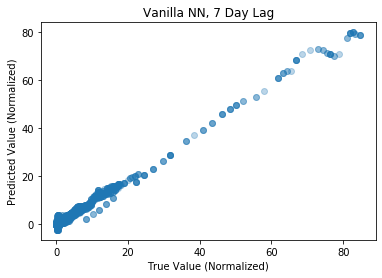

In [40]:
# plot predictions against real
plt.scatter(test_targets, vanilla_nn7.predict(test_inputs), alpha=0.3)
plt.xlabel('True Value (Normalized)')
plt.ylabel('Predicted Value (Normalized)')
plt.title('Vanilla NN, 7 Day Lag')
plt.show()

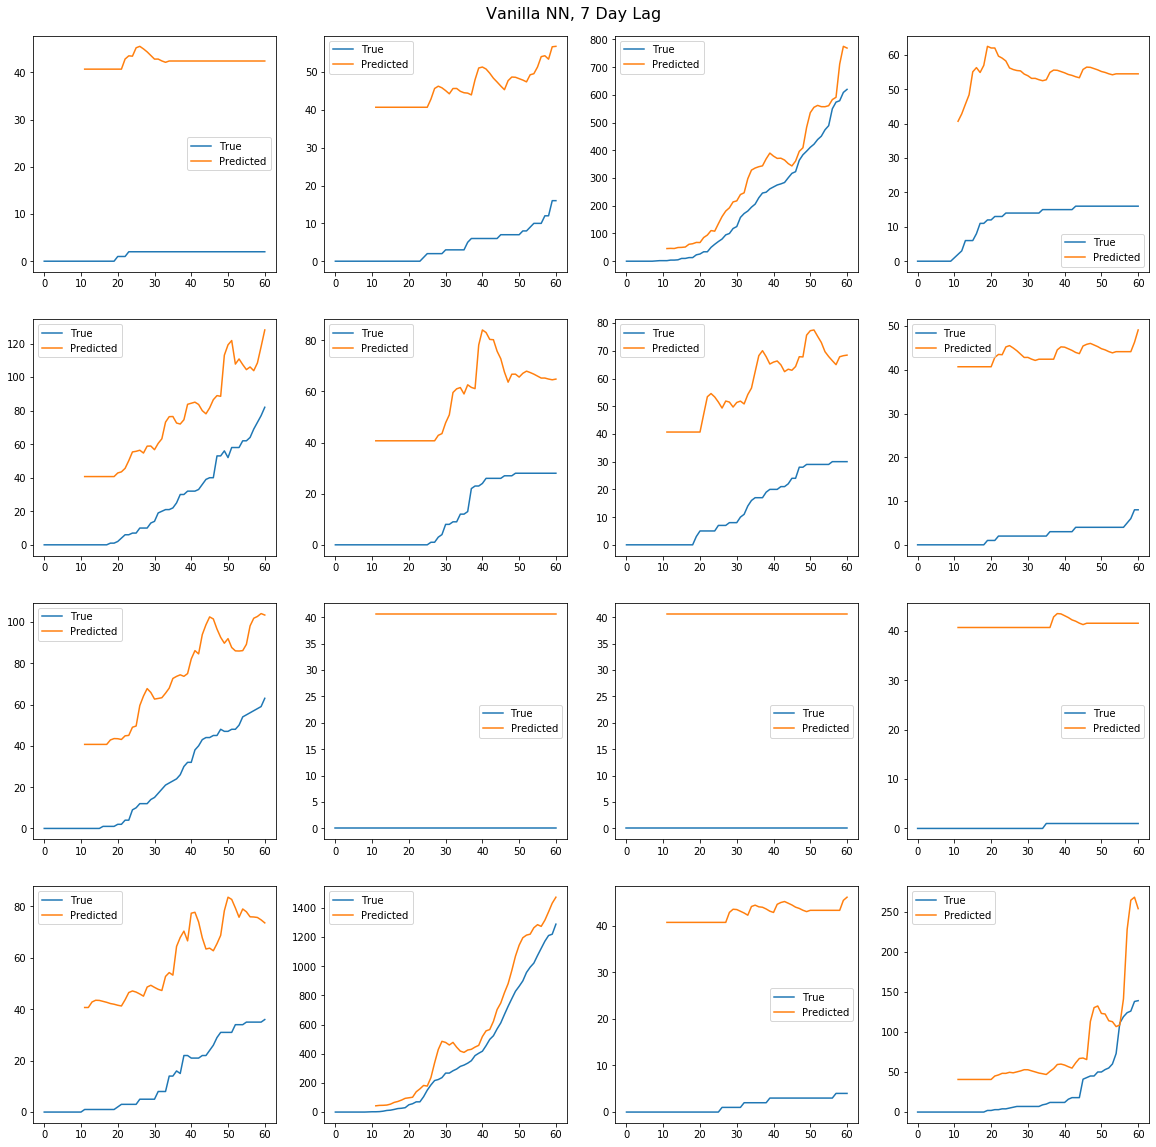

In [107]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_pred = inv_normalize(vanilla_nn7.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.suptitle('Vanilla NN, 7 Day Lag', fontsize=16, y=0.9)
plt.show()

# Model 1. Vanilla feedforward NN
## 1 day lag

In [25]:
# model params
n_units = 50
dropout_rate = 0.05

# construct feedforward NN with one hidden layer
vanilla_nn1 = models.Sequential()
vanilla_nn1.add(layers.Dense(n_units, input_dim=(n_timesteps)))
vanilla_nn1.add(layers.Dense(1))
vanilla_nn1.add(layers.Dropout(dropout_rate))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vanilla_nn1.compile(loss='mean_squared_error', optimizer=optimizer)

In [26]:
# training data params
n_train = 1000000
n_batch = 1
lag = 1

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False)

In [27]:
# fit model
n_epoch = 50

vnn1_history = vanilla_nn1.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.1609 - val_loss: 0.0034
Epoch 2/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.1114 - val_loss: 0.0026
Epoch 3/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.6350 - val_loss: 0.2474
Epoch 4/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.1052 - val_loss: 0.0096
Epoch 5/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.1145 - val_loss: 0.6150
Epoch 6/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.1400 - val_loss: 0.0061
Epoch 7/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.0812 - val_loss: 0.0043
Epoch 8/50
1000000/1000000 [==============================] - 1s 1us/sample - loss: 0.1325 - val_loss: 0.0074
Epoch 9/50
1000000/1000000 [==============================] - 1s 1u

In [28]:
# evaluate on test set
test_loss = vanilla_nn1.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 3s 15us/sample - loss: 0.0064
Test loss: 0.006421411383952945


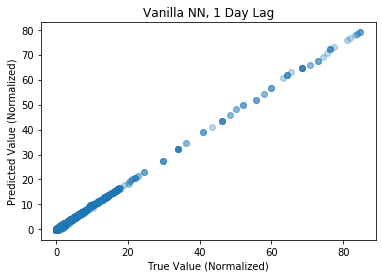

In [29]:
# plot predictions against real
plt.scatter(test_targets, vanilla_nn1.predict(test_inputs), alpha=0.3)
plt.xlabel('True Value (Normalized)')
plt.ylabel('Predicted Value (Normalized)')
plt.title('Vanilla NN, 1 Day Lag')
plt.show()

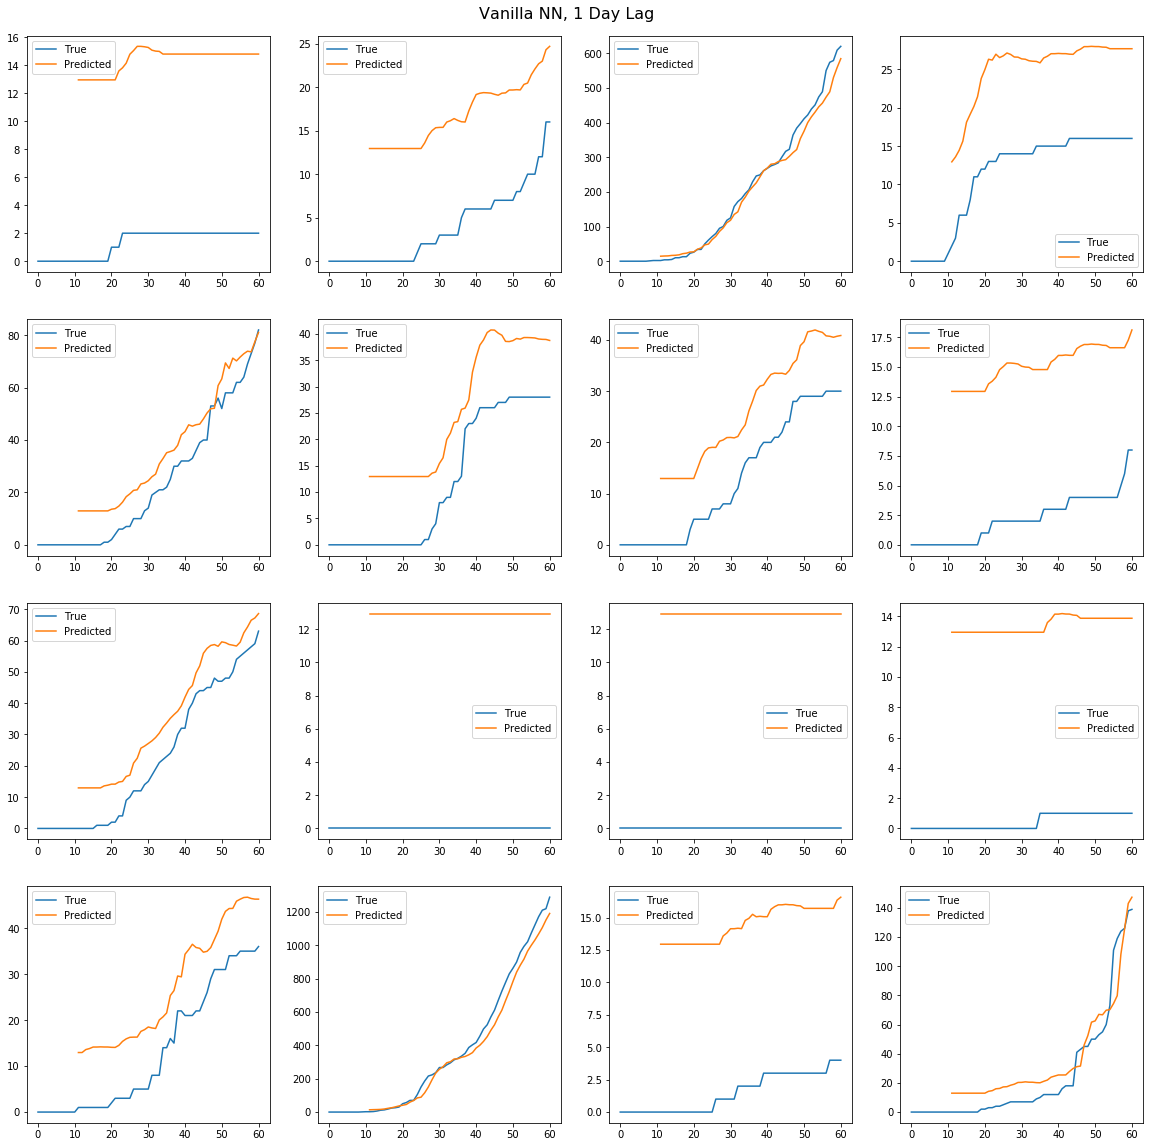

In [106]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_pred = inv_normalize(vanilla_nn1.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.suptitle('Vanilla NN, 1 Day Lag', fontsize=16, y=0.9)
plt.show()

# Model 2. Vanilla LSTM
## 7 day lag

In [42]:
# model params
n_units = 50
dropout_rate = 0.05

# construct simple LSTM with one hidden layer
vanilla_lstm7 = models.Sequential()
vanilla_lstm7.add(layers.LSTM(n_units, input_shape=(n_timesteps, 1)))
vanilla_lstm7.add(layers.Dropout(dropout_rate))
vanilla_lstm7.add(layers.Dense(1))
vanilla_lstm7.compile(optimizer='adam', loss='mse')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vanilla_lstm7.compile(loss='mean_squared_error', optimizer=optimizer)
vanilla_lstm7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [43]:
# training data params
n_train = 1000000
n_batch = 1
lag = 7

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False,
                                                                lstm=True)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False,
                                                             lstm=True)

In [44]:
# fit model
n_epoch = 10

vlstm7_history = vanilla_lstm7.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/10
1000000/1000000 [==============================] - 27s 27us/sample - loss: 0.8907 - val_loss: 0.5696
Epoch 2/10
1000000/1000000 [==============================] - 24s 24us/sample - loss: 0.3062 - val_loss: 0.2078
Epoch 3/10
1000000/1000000 [==============================] - 23s 23us/sample - loss: 0.1159 - val_loss: 0.0804
Epoch 4/10
1000000/1000000 [==============================] - 25s 25us/sample - loss: 0.0482 - val_loss: 0.0302
Epoch 5/10
1000000/1000000 [==============================] - 25s 25us/sample - loss: 0.0241 - val_loss: 0.0149
Epoch 6/10
1000000/1000000 [==============================] - 26s 26us/sample - loss: 0.0166 - val_loss: 0.0102
Epoch 7/10
1000000/1000000 [==============================] - 24s 24us/sample - loss: 0.0140 - val_loss: 0.0102
Epoch 8/10
1000000/1000000 [==============================] - 24s 24us/sample - loss: 0.0137 - val_loss: 0.0107
Epoch 9/10
1000000/1000000 [=======================

In [45]:
# evaluate on test set
test_loss = vanilla_lstm7.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 9s 44us/sample - loss: 0.0103
Test loss: 0.010298489789727028


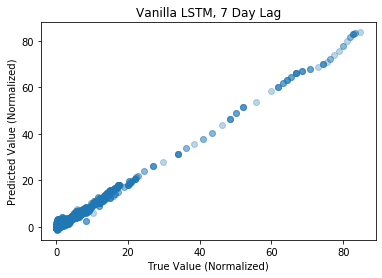

In [46]:
# plot predictions against real
plt.scatter(test_targets, vanilla_lstm7.predict(test_inputs), alpha=0.3)
plt.xlabel('True Value (Normalized)')
plt.ylabel('Predicted Value (Normalized)')
plt.title('Vanilla LSTM, 7 Day Lag')
plt.show()

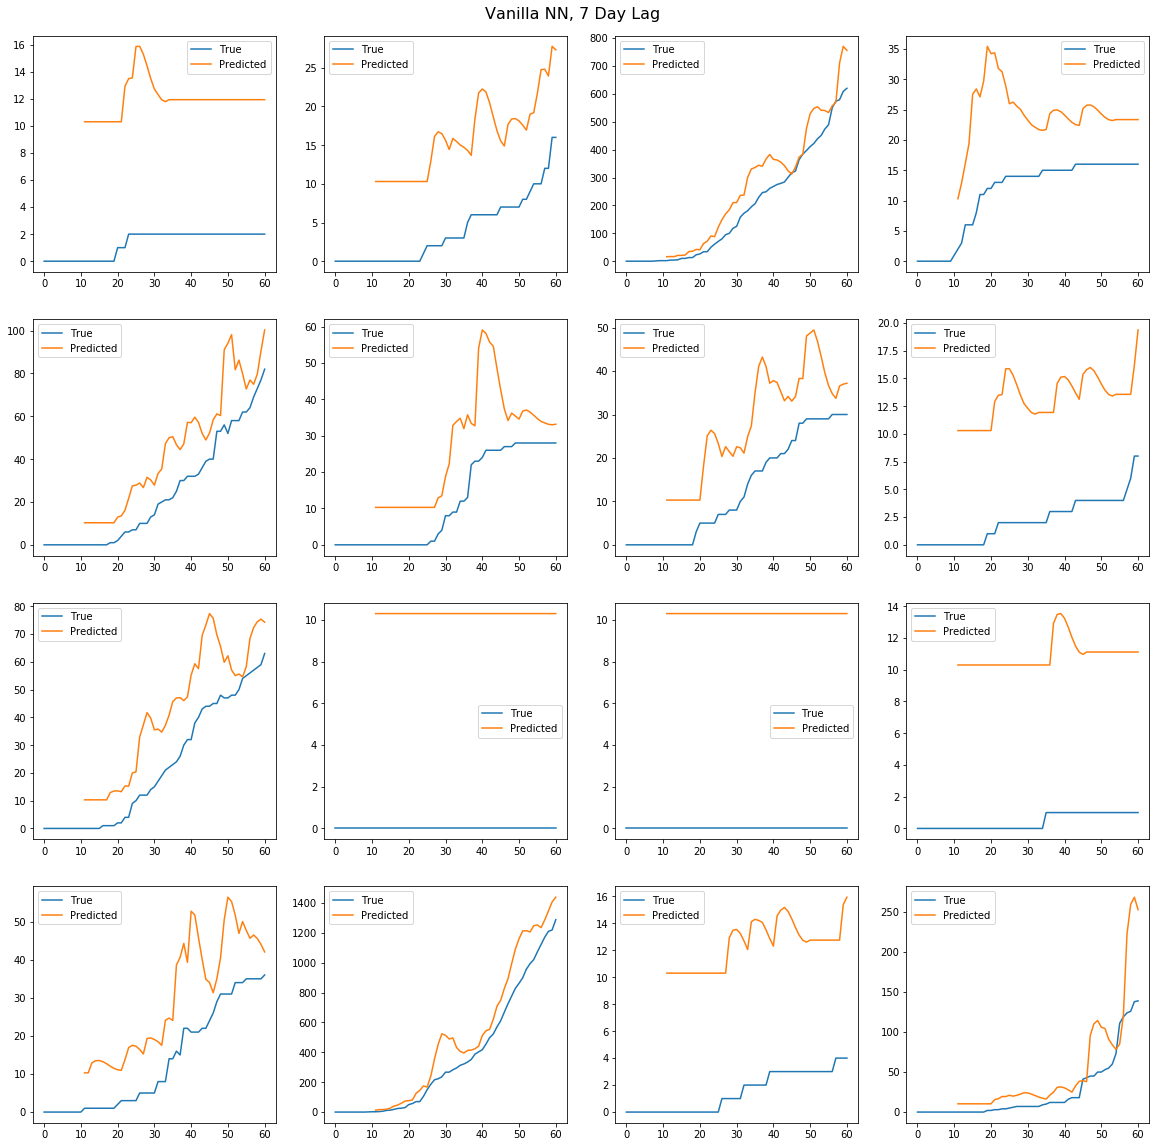

In [105]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_input = sample_input.reshape(sample_input.shape[0], sample_input.shape[1], 1)
    sample_pred = inv_normalize(vanilla_lstm7.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.suptitle('Vanilla NN, 7 Day Lag', fontsize=16, y=0.9)
plt.show()

# Model 2. Vanilla LSTM
## 1 day lag

In [48]:
# model params
n_units = 50
dropout_rate = 0.05

# construct simple LSTM with one hidden layer
vanilla_lstm1 = models.Sequential()
vanilla_lstm1.add(layers.LSTM(n_units, input_shape=(n_timesteps, 1)))
vanilla_lstm1.add(layers.Dropout(dropout_rate))
vanilla_lstm1.add(layers.Dense(1))
vanilla_lstm1.compile(optimizer='adam', loss='mse')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vanilla_lstm1.compile(loss='mean_squared_error', optimizer=optimizer)
vanilla_lstm1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [49]:
# training data params
n_train = 1000000
n_batch = 1
lag = 1

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False,
                                                                lstm=True)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False,
                                                             lstm=True)

In [50]:
# fit model
n_epoch = 10

vlstm1_history = vanilla_lstm1.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/10
1000000/1000000 [==============================] - 28s 28us/sample - loss: 0.9034 - val_loss: 0.4123
Epoch 2/10
1000000/1000000 [==============================] - 25s 25us/sample - loss: 0.3562 - val_loss: 0.1698
Epoch 3/10
1000000/1000000 [==============================] - 24s 24us/sample - loss: 0.1470 - val_loss: 0.0632
Epoch 4/10
1000000/1000000 [==============================] - 24s 24us/sample - loss: 0.0546 - val_loss: 0.0198
Epoch 5/10
1000000/1000000 [==============================] - 25s 25us/sample - loss: 0.0232 - val_loss: 0.0063
Epoch 6/10
1000000/1000000 [==============================] - 24s 24us/sample - loss: 0.0120 - val_loss: 0.0027
Epoch 7/10
1000000/1000000 [==============================] - 24s 24us/sample - loss: 0.0072 - val_loss: 9.5659e-04
Epoch 8/10
1000000/1000000 [==============================] - 24s 24us/sample - loss: 0.0060 - val_loss: 0.0019
Epoch 9/10
1000000/1000000 [===================

In [51]:
# evaluate on test set
test_loss = vanilla_lstm1.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 8s 41us/sample - loss: 0.0013
Test loss: 0.0013278351827553706


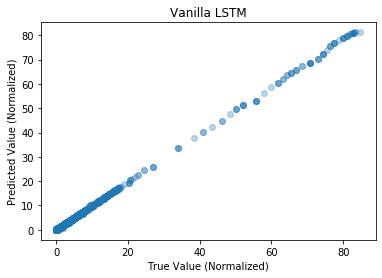

In [52]:
# plot predictions against real
plt.scatter(test_targets, vanilla_lstm1.predict(test_inputs), alpha=0.3)
plt.xlabel('True Value (Normalized)')
plt.ylabel('Predicted Value (Normalized)')
plt.title('Vanilla LSTM, 1 Day Lag')
plt.show()

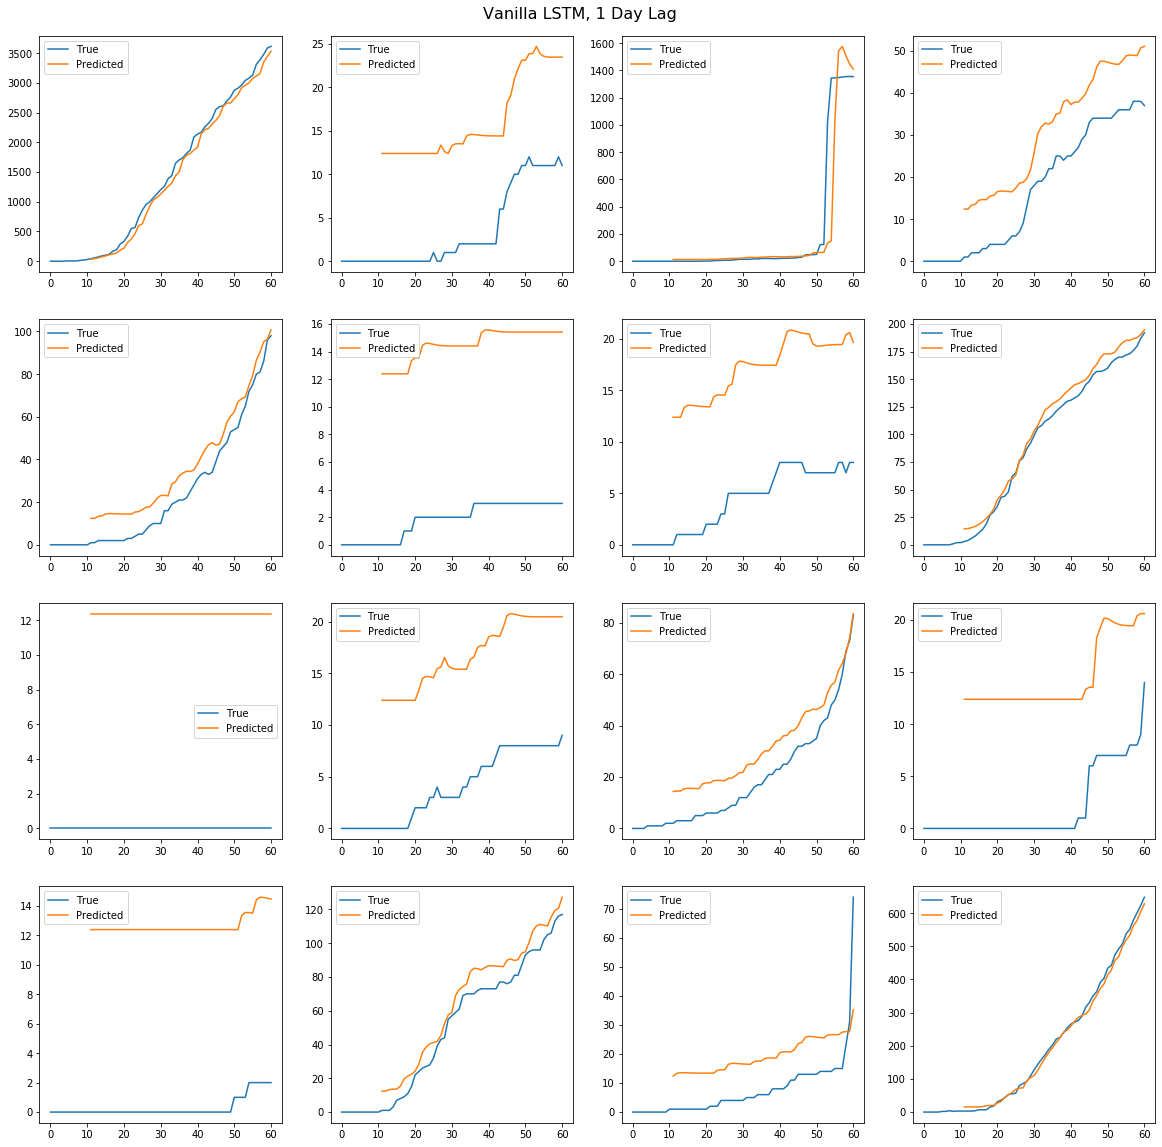

In [53]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_input = sample_input.reshape(sample_input.shape[0], sample_input.shape[1], 1)
    sample_pred = inv_normalize(vanilla_lstm1.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.suptitle('Vanilla LSTM, 1 Day Lag', fontsize=16, y=0.9)
plt.show()

# Model 3. Vanilla GRU
## 7 day lag

In [56]:
# model params
n_units = 50
dropout_rate = 0.05

# construct simple GRU with one hidden layer
vanilla_gru7 = models.Sequential()
vanilla_gru7.add(layers.GRU(n_units, input_shape=(n_timesteps, 1)))
vanilla_gru7.add(layers.Dropout(dropout_rate))
vanilla_gru7.add(layers.Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vanilla_gru7.compile(loss='mean_squared_error', optimizer=optimizer)
vanilla_gru7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                7950      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [57]:
# training data params
n_train = 1000000
n_batch = 1
lag = 7

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False,
                                                                lstm=True)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False,
                                                             lstm=True)

In [58]:
# fit model
n_epoch = 10

gru7_history = vanilla_gru7.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/10
1000000/1000000 [==============================] - 22s 22us/sample - loss: 1.0903 - val_loss: 0.5767
Epoch 2/10
1000000/1000000 [==============================] - 21s 21us/sample - loss: 0.3960 - val_loss: 0.2011
Epoch 3/10
1000000/1000000 [==============================] - 19s 19us/sample - loss: 0.1416 - val_loss: 0.0702
Epoch 4/10
1000000/1000000 [==============================] - 19s 19us/sample - loss: 0.0514 - val_loss: 0.0283
Epoch 5/10
1000000/1000000 [==============================] - 20s 20us/sample - loss: 0.0262 - val_loss: 0.0147
Epoch 6/10
1000000/1000000 [==============================] - 20s 20us/sample - loss: 0.0169 - val_loss: 0.0124
Epoch 7/10
1000000/1000000 [==============================] - 20s 20us/sample - loss: 0.0154 - val_loss: 0.0114
Epoch 8/10
1000000/1000000 [==============================] - 20s 20us/sample - loss: 0.0138 - val_loss: 0.0104
Epoch 9/10
1000000/1000000 [=======================

In [59]:
# evaluate on test set
test_loss = vanilla_gru7.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 8s 40us/sample - loss: 0.0078
Test loss: 0.00784515104300517


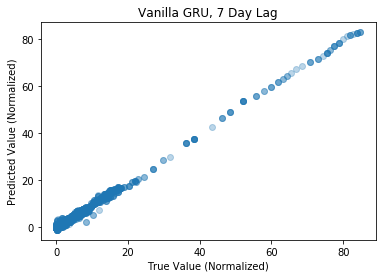

In [60]:
# plot predictions against real
plt.scatter(test_targets, vanilla_gru7.predict(test_inputs), alpha=0.3)
plt.xlabel('True Value (Normalized)')
plt.ylabel('Predicted Value (Normalized)')
plt.title('Vanilla GRU, 7 Day Lag')
plt.show()

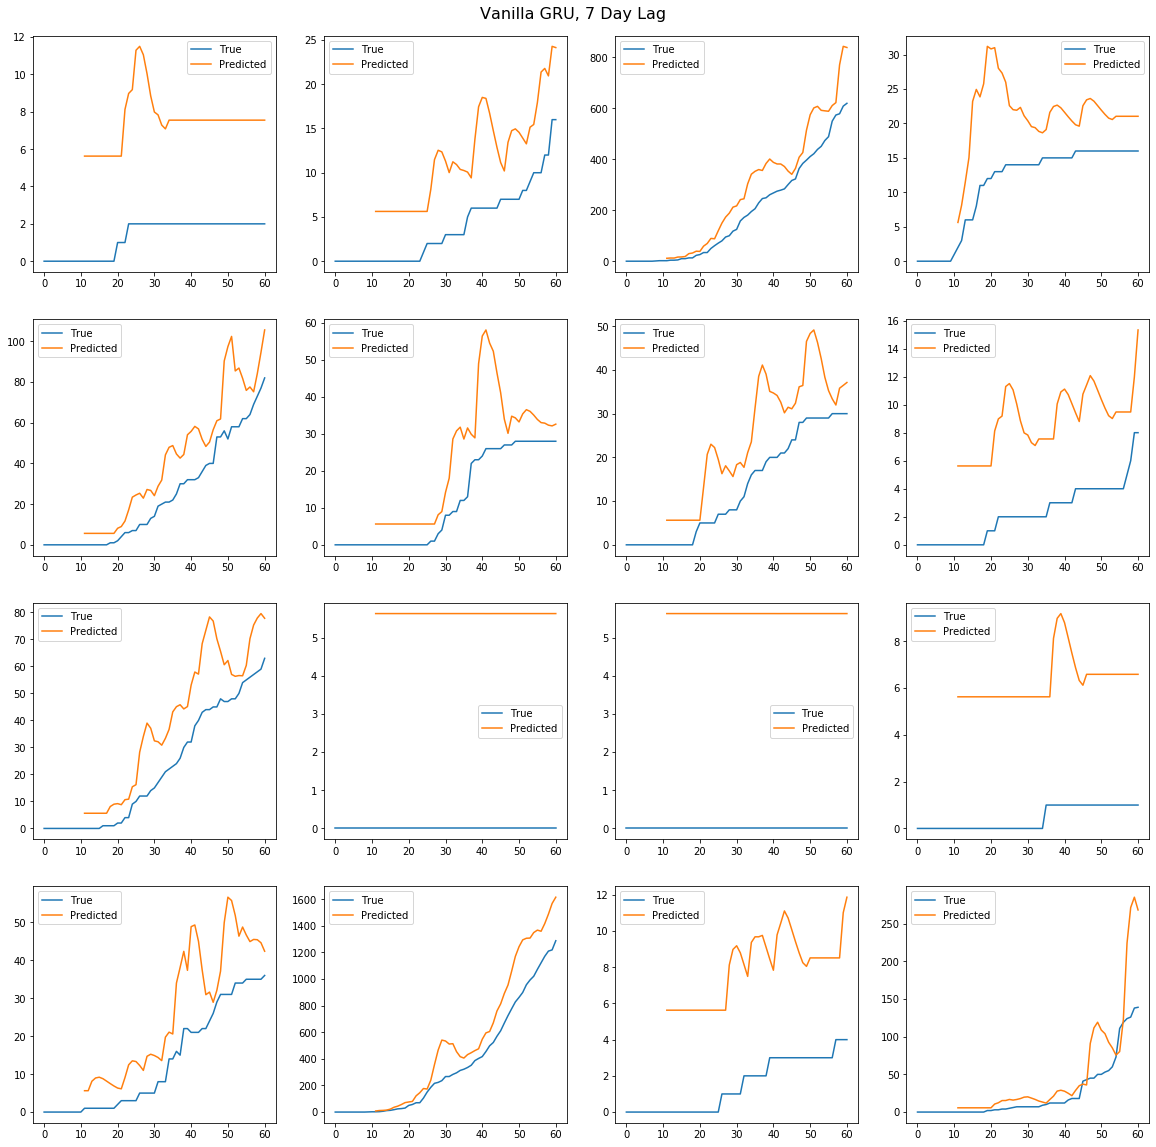

In [104]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_input = sample_input.reshape(sample_input.shape[0], sample_input.shape[1], 1)
    sample_pred = inv_normalize(vanilla_gru7.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.suptitle('Vanilla GRU, 7 Day Lag', fontsize=16, y=0.9)
plt.show()

# Model 3. Vanilla GRU
## 1 day lag

In [63]:
# model params
n_units = 50
dropout_rate = 0.05

# construct simple GRU with one hidden layer
vanilla_gru1 = models.Sequential()
vanilla_gru1.add(layers.GRU(n_units, input_shape=(n_timesteps, 1)))
vanilla_gru1.add(layers.Dropout(dropout_rate))
vanilla_gru1.add(layers.Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
vanilla_gru1.compile(loss='mean_squared_error', optimizer=optimizer)
vanilla_gru1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 50)                7950      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [64]:
# training data params
n_train = 1000000
n_batch = 1
lag = 1

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False,
                                                                lstm=True)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False,
                                                             lstm=True)

In [66]:
# fit model
n_epoch = 10

gru_history2 = vanilla_gru1.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/10
1000000/1000000 [==============================] - 22s 22us/sample - loss: 0.6191 - val_loss: 0.3523
Epoch 2/10
1000000/1000000 [==============================] - 20s 20us/sample - loss: 0.2490 - val_loss: 0.1398
Epoch 3/10
1000000/1000000 [==============================] - 21s 21us/sample - loss: 0.0982 - val_loss: 0.0538
Epoch 4/10
1000000/1000000 [==============================] - 20s 20us/sample - loss: 0.0376 - val_loss: 0.0188
Epoch 5/10
1000000/1000000 [==============================] - 19s 19us/sample - loss: 0.0163 - val_loss: 0.0114
Epoch 6/10
1000000/1000000 [==============================] - 20s 20us/sample - loss: 0.0075 - val_loss: 0.0036
Epoch 7/10
1000000/1000000 [==============================] - 20s 20us/sample - loss: 0.0059 - val_loss: 0.0071
Epoch 8/10
1000000/1000000 [==============================] - 20s 20us/sample - loss: 0.0055 - val_loss: 0.0011
Epoch 9/10
1000000/1000000 [=======================

In [67]:
# evaluate on test set
test_loss = vanilla_gru1.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 8s 41us/sample - loss: 0.0015
Test loss: 0.0014726658825857158


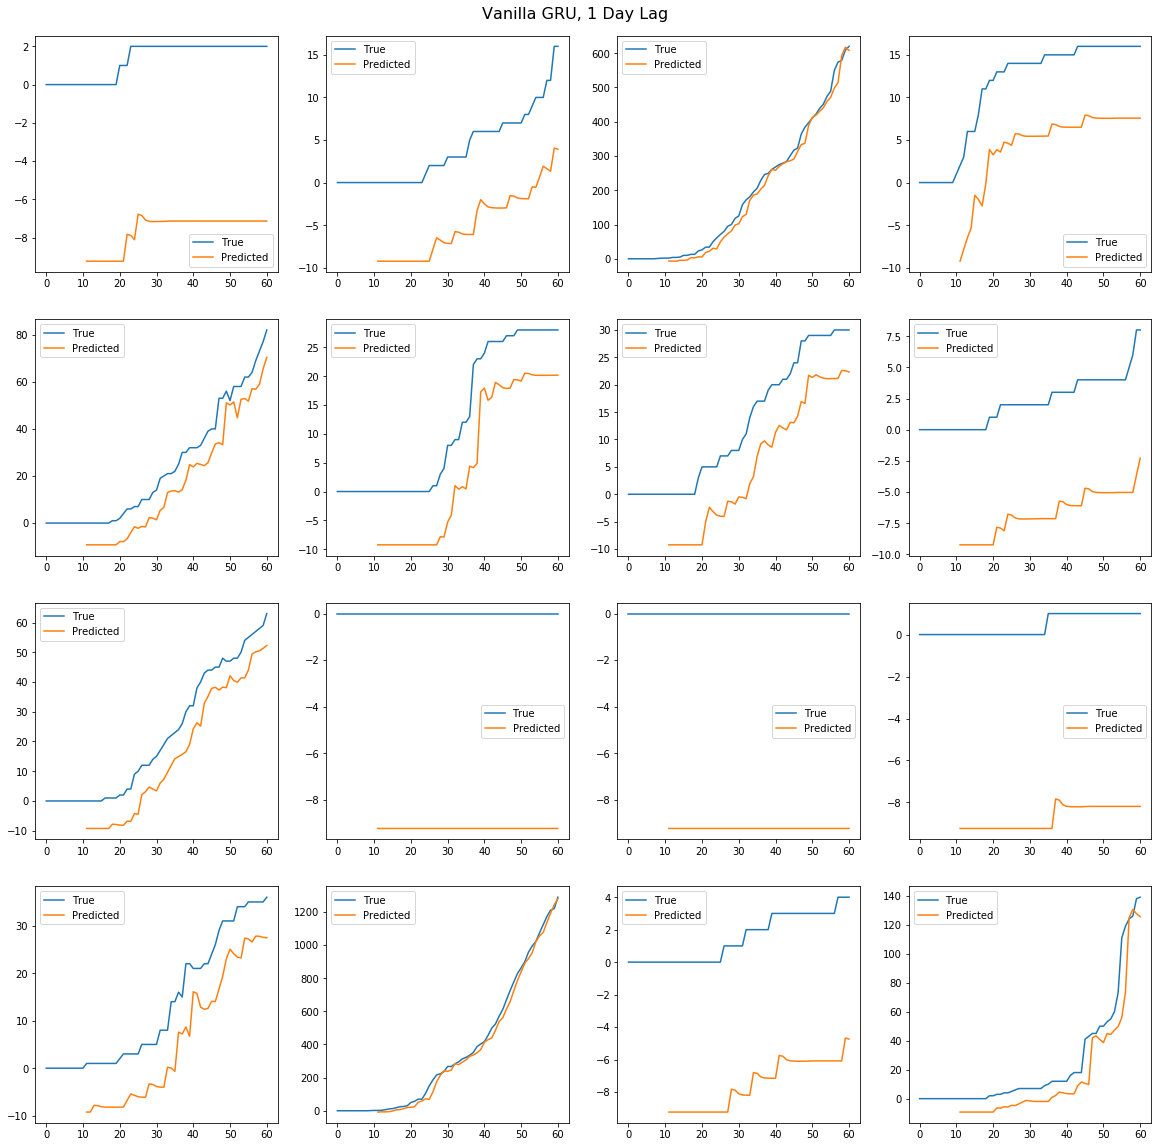

In [103]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_input = sample_input.reshape(sample_input.shape[0], sample_input.shape[1], 1)
    sample_pred = inv_normalize(vanilla_gru1.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.suptitle('Vanilla GRU, 1 Day Lag', fontsize=16, y=0.9)
plt.show()

# Model 4. Stacked LSTM
## 7 day lag

In [72]:
# model params
n_units = 50
dropout_rate = 0.05

# construct stackedd LSTM with 2 layers
stacked_lstm7 = models.Sequential()
stacked_lstm7.add(layers.LSTM(n_units, return_sequences=True, input_shape=(n_timesteps, 1)))
stacked_lstm7.add(layers.Dropout(dropout_rate))
stacked_lstm7.add(layers.LSTM(n_units * 2,  return_sequences=False))
stacked_lstm7.add(layers.Dropout(dropout_rate))
stacked_lstm7.add(layers.Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
stacked_lstm7.compile(loss='mean_squared_error', optimizer=optimizer)
stacked_lstm7.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [73]:
# training data params
n_train = 1000000
n_batch = 1
lag = 7

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False,
                                                                lstm=True)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False,
                                                             lstm=True)

In [74]:
# fit model
n_epoch = 5

stacked_lstm7_history = stacked_lstm7.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/5
1000000/1000000 [==============================] - 83s 83us/sample - loss: 0.1950 - val_loss: 0.0188
Epoch 2/5
1000000/1000000 [==============================] - 83s 83us/sample - loss: 0.0301 - val_loss: 0.0132
Epoch 3/5
1000000/1000000 [==============================] - 81s 81us/sample - loss: 0.0169 - val_loss: 0.0153
Epoch 4/5
1000000/1000000 [==============================] - 82s 82us/sample - loss: 0.0196 - val_loss: 0.0115
Epoch 5/5
1000000/1000000 [==============================] - 81s 81us/sample - loss: 0.0216 - val_loss: 0.0123


In [75]:
# evaluate on test set
test_loss = stacked_lstm7.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 19s 93us/sample - loss: 0.0126
Test loss: 0.012582891898612725


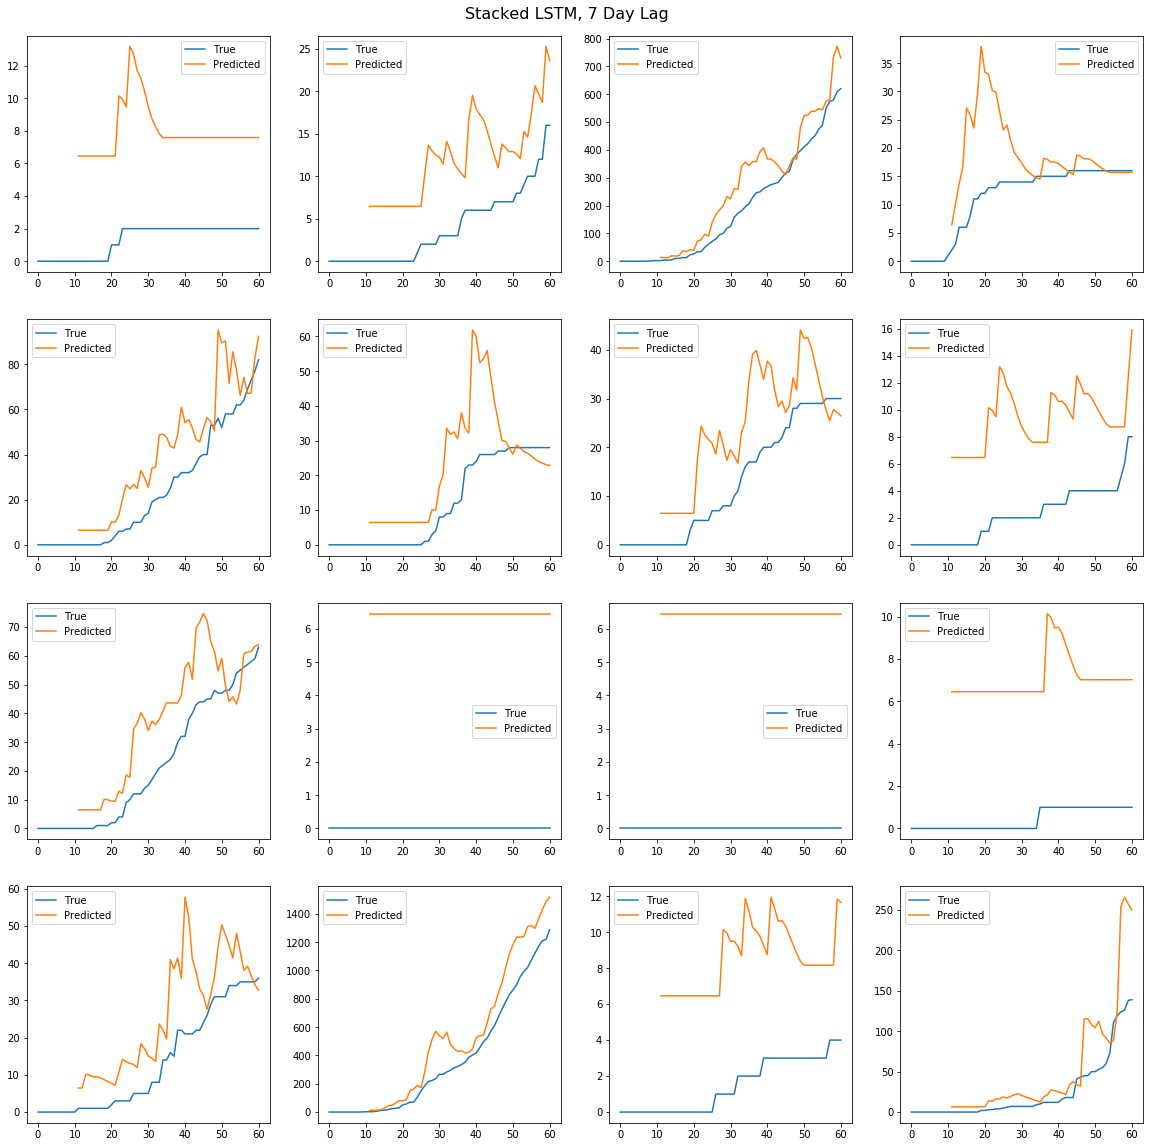

In [102]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_input = sample_input.reshape(sample_input.shape[0], sample_input.shape[1], 1)
    sample_pred = inv_normalize(stacked_lstm7.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.suptitle('Stacked LSTM, 7 Day Lag', fontsize=16, y=0.9)
plt.show()

# Model 4. Stacked LSTM
## 1 day lag

In [77]:
# model params
n_units = 50
dropout_rate = 0.05

# construct stackedd LSTM with 2 layers
stacked_lstm1 = models.Sequential()
stacked_lstm1.add(layers.LSTM(n_units, return_sequences=True, input_shape=(n_timesteps, 1)))
stacked_lstm1.add(layers.Dropout(dropout_rate))
stacked_lstm1.add(layers.LSTM(n_units * 2,  return_sequences=False))
stacked_lstm1.add(layers.Dropout(dropout_rate))
stacked_lstm1.add(layers.Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
stacked_lstm1.compile(loss='mean_squared_error', optimizer=optimizer)
stacked_lstm1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [78]:
# training data params
n_train = 1000000
n_batch = 1
lag = 1

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False,
                                                                lstm=True)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False,
                                                             lstm=True)

In [79]:
# fit model
n_epoch = 5

stacked_lstm1_history = stacked_lstm1.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/5
1000000/1000000 [==============================] - 86s 86us/sample - loss: 0.1939 - val_loss: 0.0195
Epoch 2/5
1000000/1000000 [==============================] - 83s 83us/sample - loss: 0.0228 - val_loss: 0.0053
Epoch 3/5
1000000/1000000 [==============================] - 83s 83us/sample - loss: 0.0093 - val_loss: 0.0031
Epoch 4/5
1000000/1000000 [==============================] - 83s 83us/sample - loss: 0.0096 - val_loss: 0.0051
Epoch 5/5
1000000/1000000 [==============================] - 82s 82us/sample - loss: 0.0092 - val_loss: 0.0017


In [80]:
# evaluate on test set
test_loss = stacked_lstm1.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 16s 82us/sample - loss: 0.0017
Test loss: 0.001698330772726913


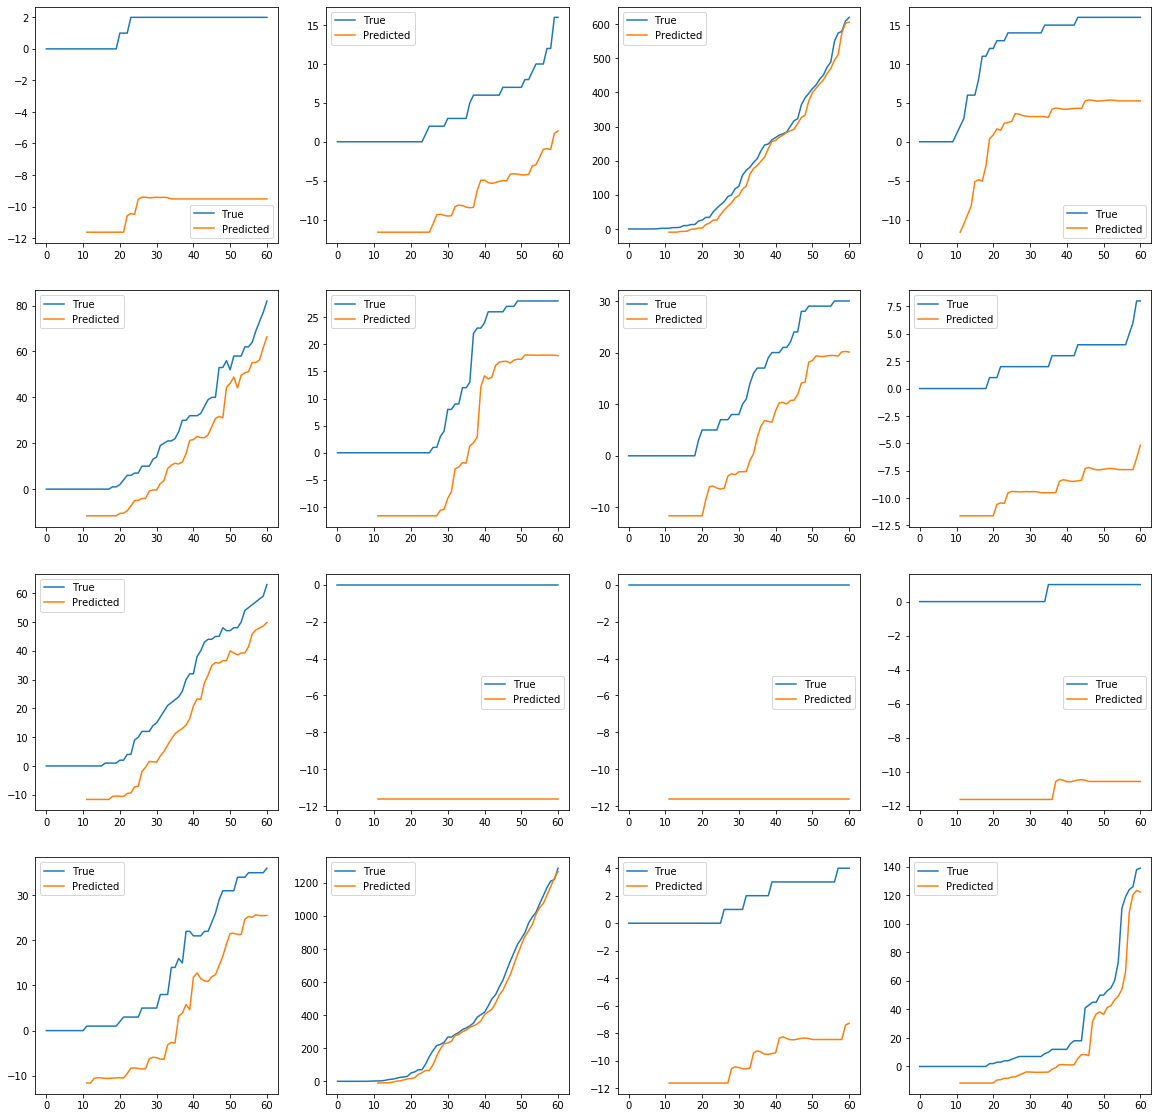

In [100]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_input = sample_input.reshape(sample_input.shape[0], sample_input.shape[1], 1)
    sample_pred = inv_normalize(stacked_lstm1.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.show()

# Model 5. Stacked GRU
## 7 day lag

In [82]:
# model params
n_units = 50
dropout_rate = 0.05

# construct stacked GRU with 2 layers
stacked_gru7 = models.Sequential()
stacked_gru7.add(layers.GRU(n_units, return_sequences=True, input_shape=(n_timesteps, 1)))
stacked_gru7.add(layers.Dropout(dropout_rate))
stacked_gru7.add(layers.GRU(n_units * 2))
stacked_gru7.add(layers.Dropout(dropout_rate))
stacked_gru7.add(layers.Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
stacked_gru7.compile(loss='mean_squared_error', optimizer=optimizer)
stacked_gru7.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 10, 50)            7950      
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 100)               45600     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 53,651
Trainable params: 53,651
Non-trainable params: 0
_________________________________________________________________


In [83]:
# training data params
n_train = 1000000
n_batch = 1
lag = 7

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False,
                                                                lstm=True)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False,
                                                             lstm=True)

In [84]:
# fit model
n_epoch = 5

stacked_gru7_history = stacked_gru7.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/5
1000000/1000000 [==============================] - 71s 71us/sample - loss: 0.1454 - val_loss: 0.0497
Epoch 2/5
1000000/1000000 [==============================] - 69s 69us/sample - loss: 0.0329 - val_loss: 0.0212
Epoch 3/5
1000000/1000000 [==============================] - 68s 68us/sample - loss: 0.0440 - val_loss: 0.0148
Epoch 4/5
1000000/1000000 [==============================] - 70s 70us/sample - loss: 0.0208 - val_loss: 0.0082
Epoch 5/5
1000000/1000000 [==============================] - 67s 67us/sample - loss: 0.0229 - val_loss: 0.0107


In [85]:
# evaluate on test set
test_loss = stacked_gru7.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 17s 85us/sample - loss: 0.0104
Test loss: 0.010426060440522852


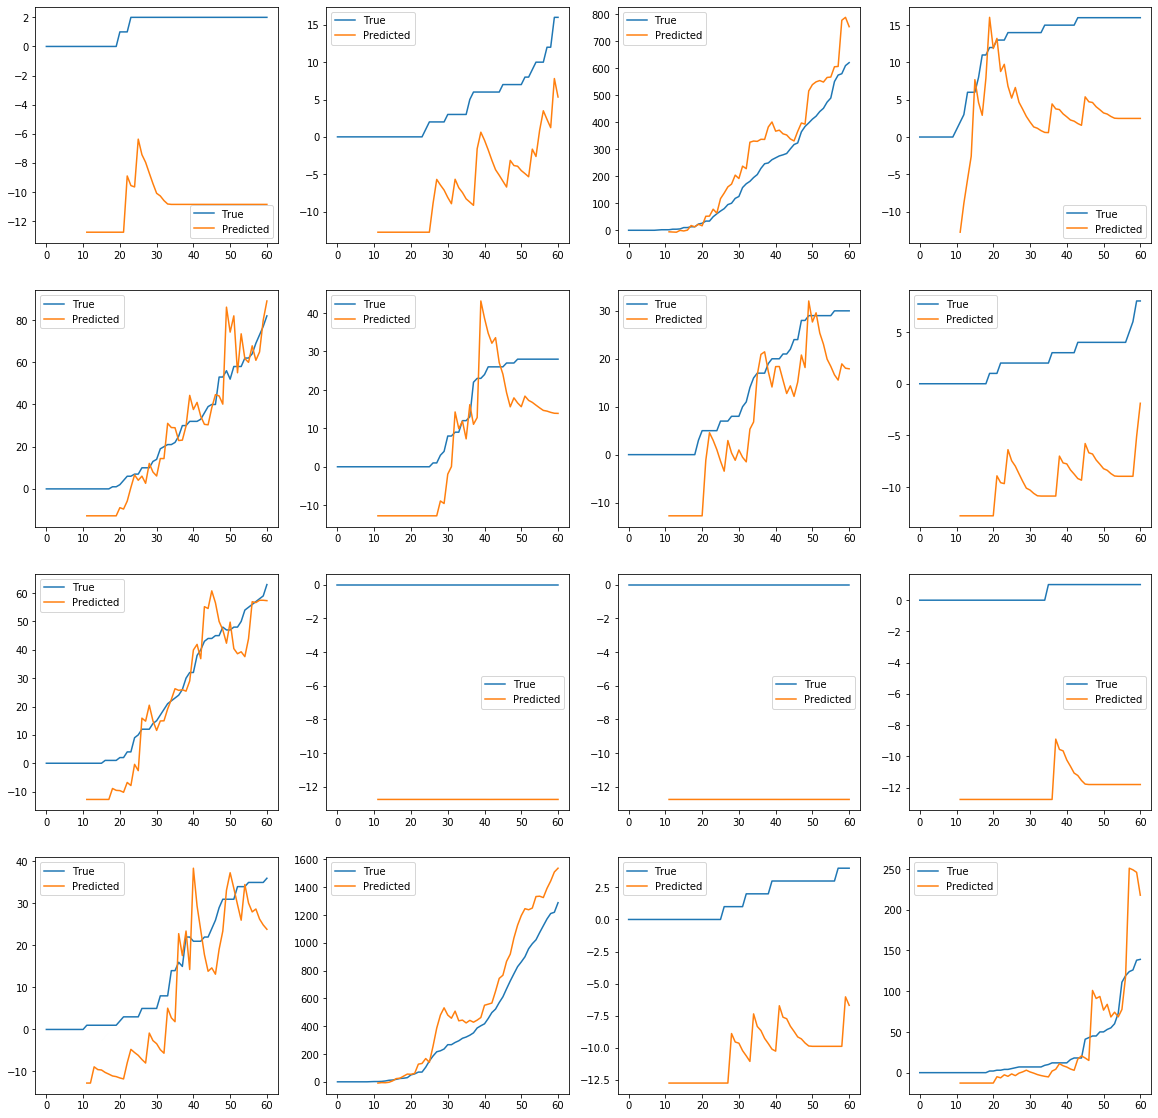

In [98]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_input = sample_input.reshape(sample_input.shape[0], sample_input.shape[1], 1)
    sample_pred = inv_normalize(stacked_gru7.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.show()

# Model 5. Stacked GRU
## 1 day lag

In [87]:
# model params
n_units = 50
dropout_rate = 0.05

# construct stacked GRU with 2 layers
stacked_gru1 = models.Sequential()
stacked_gru1.add(layers.GRU(n_units, return_sequences=True, input_shape=(n_timesteps, 1)))
stacked_gru1.add(layers.Dropout(dropout_rate))
stacked_gru1.add(layers.GRU(n_units * 2))
stacked_gru1.add(layers.Dropout(dropout_rate))
stacked_gru1.add(layers.Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
stacked_gru1.compile(loss='mean_squared_error', optimizer=optimizer)
stacked_gru1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 10, 50)            7950      
_________________________________________________________________
dropout_17 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 100)               45600     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 53,651
Trainable params: 53,651
Non-trainable params: 0
_________________________________________________________________


In [88]:
# training data params
n_train = 1000000
n_batch = 1
lag = 1

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=False,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_norm, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=False,
                                                                lstm=True)
test_inputs, test_targets, test_cond = create_training_batch(covid_norm, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=False,
                                                             lstm=True)

In [89]:
# fit model
n_epoch = 5

stacked_gru1_history = stacked_gru1.fit(x=train_inputs, 
                          y=train_targets, 
                          validation_data=(valid_inputs, valid_targets),
                          epochs=n_epoch, 
                          batch_size=1000,
                          verbose=1, 
                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/5
1000000/1000000 [==============================] - 72s 72us/sample - loss: 0.1123 - val_loss: 0.0373
Epoch 2/5
1000000/1000000 [==============================] - 67s 67us/sample - loss: 0.0415 - val_loss: 0.0040
Epoch 3/5
1000000/1000000 [==============================] - 68s 68us/sample - loss: 0.0303 - val_loss: 0.0108
Epoch 4/5
1000000/1000000 [==============================] - 68s 68us/sample - loss: 0.0206 - val_loss: 0.0061
Epoch 5/5
1000000/1000000 [==============================] - 68s 68us/sample - loss: 0.0310 - val_loss: 0.0033


In [90]:
# evaluate on test set
test_loss = stacked_gru1.evaluate(test_inputs, test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 15s 75us/sample - loss: 0.0038
Test loss: 0.003802317360443449


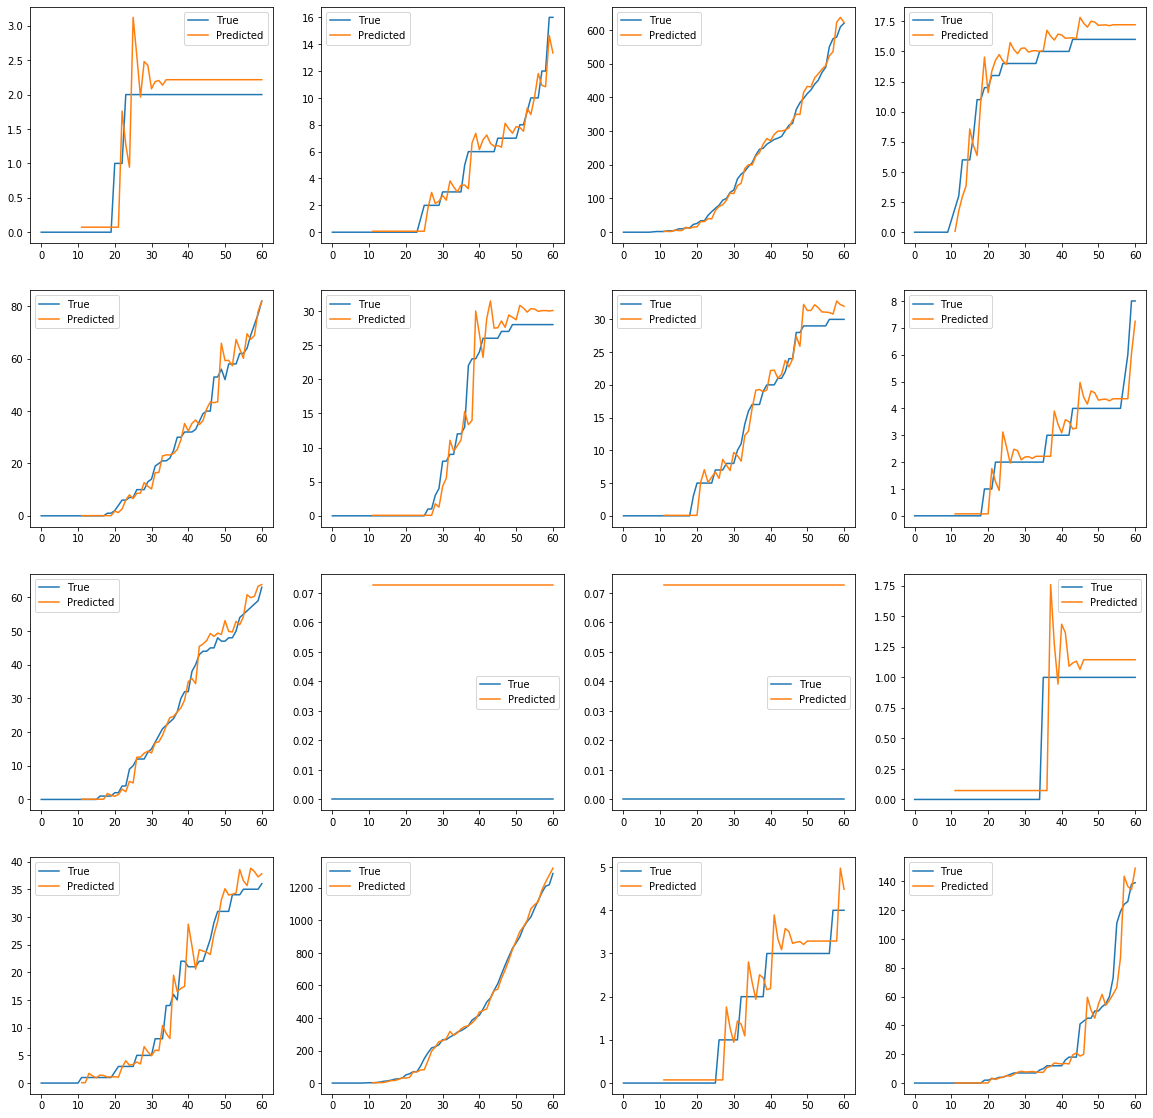

In [99]:
# plot model predictions for 16 random samples 
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
np.random.seed(100)

for ax in axes.ravel():
    sample_idx = np.random.choice(len(covid_norm))
    sample_input = create_sequential_time_series(covid_norm[sample_idx])[:,:10]
    sample_input = sample_input.reshape(sample_input.shape[0], sample_input.shape[1], 1)
    sample_pred = inv_normalize(stacked_gru1.predict(sample_input))
    ax.plot(np.arange(61), inv_normalize(covid_norm[sample_idx]), label='True')
    ax.plot(np.arange(61 - n_timesteps - lag) + n_timesteps + lag, sample_pred.flatten()[:len(sample_pred.flatten()) - n_timesteps - lag], label='Predicted')
    ax.legend()
plt.show()

# Model 6. Conditional LSTM
## Restructuring data for input into conditional LSTM

Our last model requires many conditional / constant data inputs in addition to the time series data that we have used for the preceding models. We prepared the conditional data at the start of this section and adjust our approach slightly here so that our model is compatible with said data. Note that normalization was necessary for much of the conditional data as well as the time series data that we used earlier.

In [121]:
# remove data entries without available conditional data
covid_us_cond = covid_us[covid_us[:, 0] != 28]
covid_us_cond = covid_us_cond[covid_us_cond[:, 0] != 56]
states_cond = np.array(states_cond)

# normalize
dataset_cond_mean = np.mean(covid_us_cond)
dataset_cond_std = np.std(covid_us_cond)

def normalize_data_cond(data):
    return (data - dataset_cond_mean) / dataset_cond_std

def inv_normalize_cond(data):
    return data * dataset_cond_std + dataset_cond_mean

# training data params
n_train = 1000000
n_batch = 1
lag = 7

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_us_cond, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=True,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_us_cond, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=True,
                                                                lstm=True)

test_inputs, test_targets, test_cond = create_training_batch(covid_us_cond, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=True,
                                                             lstm=True)

# normalize training, validation, and test data
train_inputs = normalize_data_cond(train_inputs)
train_targets = normalize_data_cond(train_targets)

valid_inputs = normalize_data_cond(valid_inputs)
valid_targets = normalize_data_cond(valid_targets)

test_inputs = normalize_data_cond(test_inputs)
test_targets = normalize_data_cond(test_targets)

# Model 6. Conditional LSTM
## 7 day lag

In [127]:
# model params
n_units = 50
dropout_rate = 0.05
n_conditions = 15

# construct conditional LSTM
# input to LSTM
input_timeseries1 = layers.Input(shape=(n_timesteps, 1))
lstm_layer1 = layers.LSTM(n_units, input_shape=(n_timesteps, 1))(input_timeseries1)
flatten_layer1 = layers.Flatten()(lstm_layer1)

# concatenate LSTM output and conditional data
input_conditional1 = layers.Input(shape=(n_conditions))
concat_layer1 = layers.concatenate([lstm_layer1, input_conditional1], axis=1)

# dense layers and oputput
dense_layer1 = layers.Dense(n_units)(concat_layer1)
dropout_layer1 = layers.Dropout(dropout_rate)(dense_layer1)
output1 = layers.Dense(1)(dropout_layer1)

# compile conditional LSTM
conditional_lstm7 = tf.keras.Model([input_timeseries1, input_conditional1], output1, name='conditional_LSTM_1')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
conditional_lstm7.compile(optimizer=optimizer, loss='mse')
conditional_lstm7.summary()

Model: "conditional_LSTM_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 50)           10400       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 65)           0           lstm_9[0][0]                     
                                                                 input_4[0][0]   

In [128]:
# fit model
n_epoch = 5
cond_lstm_history = conditional_lstm7.fit(x=[train_inputs, train_cond], 
                                          y=train_targets, 
                                          validation_data=([valid_inputs, valid_cond], valid_targets),
                                          epochs=n_epoch, 
                                          batch_size=1000,
                                          verbose=1, 
                                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/5
1000000/1000000 [==============================] - 29s 29us/sample - loss: 13.2107 - val_loss: 0.0484
Epoch 2/5
1000000/1000000 [==============================] - 26s 26us/sample - loss: 0.2028 - val_loss: 0.0454
Epoch 3/5
1000000/1000000 [==============================] - 25s 25us/sample - loss: 0.0621 - val_loss: 0.0343
Epoch 4/5
1000000/1000000 [==============================] - 24s 24us/sample - loss: 0.0427 - val_loss: 0.0176
Epoch 5/5
1000000/1000000 [==============================] - 25s 25us/sample - loss: 0.0337 - val_loss: 0.0124


In [129]:
# evaluate on test set
test_loss = conditional_lstm7.evaluate([test_inputs, test_cond], test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 9s 44us/sample - loss: 0.0125
Test loss: 0.012531259518777952


# Model 6. Conditional LSTM
## 1 day lag

In [145]:
# training data params
n_train = 1000000
n_batch = 1
lag = 1

# create training, validation, and test sets, with training 5x the size of validation and test
# note that conditional data is not used here
train_inputs, train_targets, train_cond = create_training_batch(covid_us_cond, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=n_train, 
                                                                conditional=True,
                                                                lstm=True)
valid_inputs, valid_targets, valid_cond = create_training_batch(covid_us_cond, 
                                                                states_cond, 
                                                                lag=lag, 
                                                                batch_size=int(n_train / 5), 
                                                                conditional=True,
                                                                lstm=True)

test_inputs, test_targets, test_cond = create_training_batch(covid_us_cond, 
                                                             states_cond, 
                                                             lag=lag, 
                                                             batch_size=int(n_train / 5), 
                                                             conditional=True,
                                                             lstm=True)

# normalize training, validation, and test data
train_inputs = normalize_data_cond(train_inputs)
train_targets = normalize_data_cond(train_targets)

valid_inputs = normalize_data_cond(valid_inputs)
valid_targets = normalize_data_cond(valid_targets)

test_inputs = normalize_data_cond(test_inputs)
test_targets = normalize_data_cond(test_targets)

In [146]:
# model params
n_units = 50
dropout_rate = 0.05
n_conditions = 15

# construct conditional LSTM
# input to LSTM
input_timeseries = layers.Input(shape=(n_timesteps, 1))
lstm_layer = layers.LSTM(n_units, input_shape=(n_timesteps, 1))(input_timeseries)
flatten_layer = layers.Flatten()(lstm_layer)

# concatenate LSTM output and conditional data
input_conditional = layers.Input(shape=(n_conditions))
concat_layer = layers.concatenate([lstm_layer, input_conditional], axis=1)

# dense layers and oputput
dense_layer = layers.Dense(n_units)(concat_layer)
dropout_layer = layers.Dropout(dropout_rate)(dense_layer)
output = layers.Dense(1)(dropout_layer)

# compile conditional LSTM
conditional_lstm1 = tf.keras.Model([input_timeseries, input_conditional], output, name='conditional_LSTM')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
conditional_lstm1.compile(optimizer=optimizer, loss='mse')
conditional_lstm1.summary()

Model: "conditional_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 50)           10400       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 65)           0           lstm_10[0][0]                    
                                                                 input_6[0][0]     

In [152]:
# fit model
n_epoch = 5
cond_lstm_history = conditional_lstm1.fit(x=[train_inputs, train_cond], 
                                          y=train_targets, 
                                          validation_data=([valid_inputs, valid_cond], valid_targets),
                                          epochs=n_epoch, 
                                          batch_size=1000,
                                          verbose=1, 
                                          shuffle=True)

Train on 1000000 samples, validate on 200000 samples
Epoch 1/5
1000000/1000000 [==============================] - 29s 29us/sample - loss: 0.0360 - val_loss: 0.0553
Epoch 2/5
1000000/1000000 [==============================] - 28s 28us/sample - loss: 0.0274 - val_loss: 0.0101
Epoch 3/5
1000000/1000000 [==============================] - 28s 28us/sample - loss: 0.0631 - val_loss: 0.0648
Epoch 4/5
1000000/1000000 [==============================] - 28s 28us/sample - loss: 0.1856 - val_loss: 0.0033
Epoch 5/5
1000000/1000000 [==============================] - 29s 29us/sample - loss: 0.0150 - val_loss: 0.0036


In [148]:
# evaluate on test set
test_loss = conditional_lstm1.evaluate([test_inputs, test_cond], test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 10s 48us/sample - loss: 0.0307
Test loss: 0.03065814012117684


# 4. Comparison of Model Performance

We print the test MSE for the 7 day lag for all 6 models.

In [142]:
test_loss = vanilla_nn7.evaluate(test_inputs.reshape(test_inputs.shape[0], test_inputs.shape[1]), test_targets.flatten())
print(test_loss)

200000/200000 [==============================] - 3s 15us/sample - loss: 0.0164
0.016355393749452198


In [133]:
for model in [vanilla_lstm7, vanilla_gru7, stacked_lstm7, stacked_gru7]:
    test_loss = model.evaluate(test_inputs, test_targets)
    print(test_loss)

200000/200000 [==============================] - 9s 44us/sample - loss: 0.0102
0.010207908058830654
200000/200000 [==============================] - 8s 42us/sample - loss: 0.0081
0.008096132523632841
200000/200000 [==============================] - 19s 93us/sample - loss: 0.0115
0.011536280071410583
200000/200000 [==============================] - 15s 77us/sample - loss: 0.0113
0.011307780496831983


In [143]:
test_loss = conditional_lstm7.evaluate([test_inputs, test_cond], test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 9s 46us/sample - loss: 0.0125
Test loss: 0.012531259518777952


We print the test MSE for the 1 day lag for all 6 models.

In [150]:
test_loss = vanilla_nn1.evaluate(test_inputs.reshape(test_inputs.shape[0], test_inputs.shape[1]), test_targets.flatten())
print(test_loss)

200000/200000 [==============================] - 3s 17us/sample - loss: 0.0070
0.007014548131935298


In [149]:
for model in [vanilla_lstm1, vanilla_gru1, stacked_lstm1, stacked_gru1]:
    test_loss = model.evaluate(test_inputs, test_targets)
    print(test_loss)

200000/200000 [==============================] - 9s 46us/sample - loss: 9.6837e-04
0.0009683738140860806
200000/200000 [==============================] - 9s 46us/sample - loss: 9.1394e-04
0.0009139363874006085
200000/200000 [==============================] - 18s 88us/sample - loss: 0.0015
0.0014595165651640856
200000/200000 [==============================] - 15s 76us/sample - loss: 0.0034
0.0033818087560943057


In [151]:
test_loss = conditional_lstm1.evaluate([test_inputs, test_cond], test_targets)
print("Test loss:", test_loss)

200000/200000 [==============================] - 12s 60us/sample - loss: 0.0307
Test loss: 0.03065814012117684


# 5. Discussion


## Insights
We had a number of insights from our work:

1. There were somewhat limited differences in predictive performance between the 6 models, and the feedforward NN exceeded expectations for both prediction tasks (7- and 1-day).
2. In general, the vanilla GRU seemed to perform the best out of all the models for both prediction tasks, potentially because the GRU needs less data to generalize than an LSTM model. We found it had the lowest MSE for both, as printed above.
3. Counterintuitively, stacking additional LSTM and GRU layers did not seem to increase predictive performance, perhaps indicating excess model complexity for the relative simplicity of the task. 
4. MSE as a loss function is likely imbalanaced for this task due to the prevalence of low-case data. The structure of the data in general (i.e., many low-case data sequences and far fewer high case data sequences) might be a reason why our models were limited in predictive power. This poses two questions for further examination, the first being how we should properly normalize the data and the second what loss function might be better if not MSE (perhaps non-Euclidean loss?). In general, from a model principle standpoint, this seems to indicate that using blackbox methods such as NNs fares worse than more principled approaches such as an ODE-based model like SIR.


## Limitations
Some constraints that came to mind as we fit our models:
1. Model results were extremely stochastic from run to run instance, suggesting that there might be a need to average across many run instances and select the best model based on validation data. Overfitting was a substantial problem, and was mitigated to some extent by incorporating dropout layers on some of the models.
2. The conditional data that was fed to the conditional LSTM was on a state-level, whereas the time series data used to train it was on a county / town level. As such, btaining conditional data on a county / town-level might be better for improving predictive performance, as there is obviously a huge difference between NYC, for instance, and a rural town in upstate NY, so grouping them with the same state factors would be inappropriate. In general, our hypothesis here is that differences between urban and rural might be substantatially important than inter-state differences.
3. Time series data was limited only to the U.S. over a period of 60 days and thus quite sparse; incorporating data from other geographies might be helpful.
4. Better conditional data might improve predictive performance. It is likely that we did not use the right factors, which might have limited our predictive accuracy. 

## Future Work
1. Testing additional normalization approaches would be helpful, as our selection of normalization approach heavily informed model accuracy.
2. Averaging results over many run instances could provide more numerically stable results, as mentioned above. Perhaps better tuning our learning rate may also help here.
3. We haven’t applied our networks extensively for decreases in cases, as all the data was upward-trending
4. Getting data that is more granular and county / town-level might improve predictions, as we used state-level data instead.
5. Adapting our neural network approach to a hybrid approach where we estimate parameters of an ODE model might be a more principled approach, and in general we should be skeptical of blackbox models, as evidenced by our work. Unfortunately, a NN doesn't tell us what is driving the disease increase, which is inherently constraining. alternatively, a classifical statistical model such as a GLM or GAM mighht work well to indicate what particulr factors are driving high counts.

# 6. References for Introduction and EDA
Aburas, H. M., Cetiner, B. G., & Sari, M. (2010). Dengue confirmed-cases prediction: A neural network model. Expert Systems with Applications, 37(6), 4256–4260. https://doi.org/10.1016/j.eswa.2009.11.077

Casselman, B. (2020, April 29). Worst Economy in a Decade. What’s Next? ‘Worst in Our Lifetime.’ The New York Times. https://www.nytimes.com/2020/04/29/business/economy/us-gdp.html
CDC. (2020, February 11). Coronavirus Disease 2019 (COVID-19). Centers for Disease Control and Prevention. https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/racial-ethnic-minorities.html

Emily Aiken, Andre Nguyen, & Mauricio Santillana. (2019, November 13). [1911.02673] Towards the Use of Neural Networks for Influenza Prediction at Multiple Spatial Resolutions. https://arxiv.org/abs/1911.02673

Liu, L., Han, M., Zhou, Y., & Wang, Y. (2018). LSTM Recurrent Neural Networks for Influenza Trends Prediction. In F. Zhang, Z. Cai, P. Skums, & S. Zhang (Eds.), Bioinformatics Research and Applications (pp. 259–264). Springer International Publishing. https://doi.org/10.1007/978-3-319-94968-0_25

Mervosh, S., Lee, J. C., Gamio, L., & Popovich, N. (n.d.). See Which States Are Reopening and Which Are Still Shut Down. The New York Times. Retrieved May 1, 2020, from https://www.nytimes.com/interactive/2020/us/states-reopen-map-coronavirus.html

Sherman, N. (2020, April 23). US unemployment claims hit 26.4 million amid virus. BBC News. https://www.bbc.com/news/business-52398837

Times, T. N. Y. (n.d.). Coronavirus in the U.S.: Latest Map and Case Count. The New York Times. Retrieved May 1, 2020, from https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html